  0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 1500: Train Loss = 6.9991e-02, Val Loss = 6.9324e-02


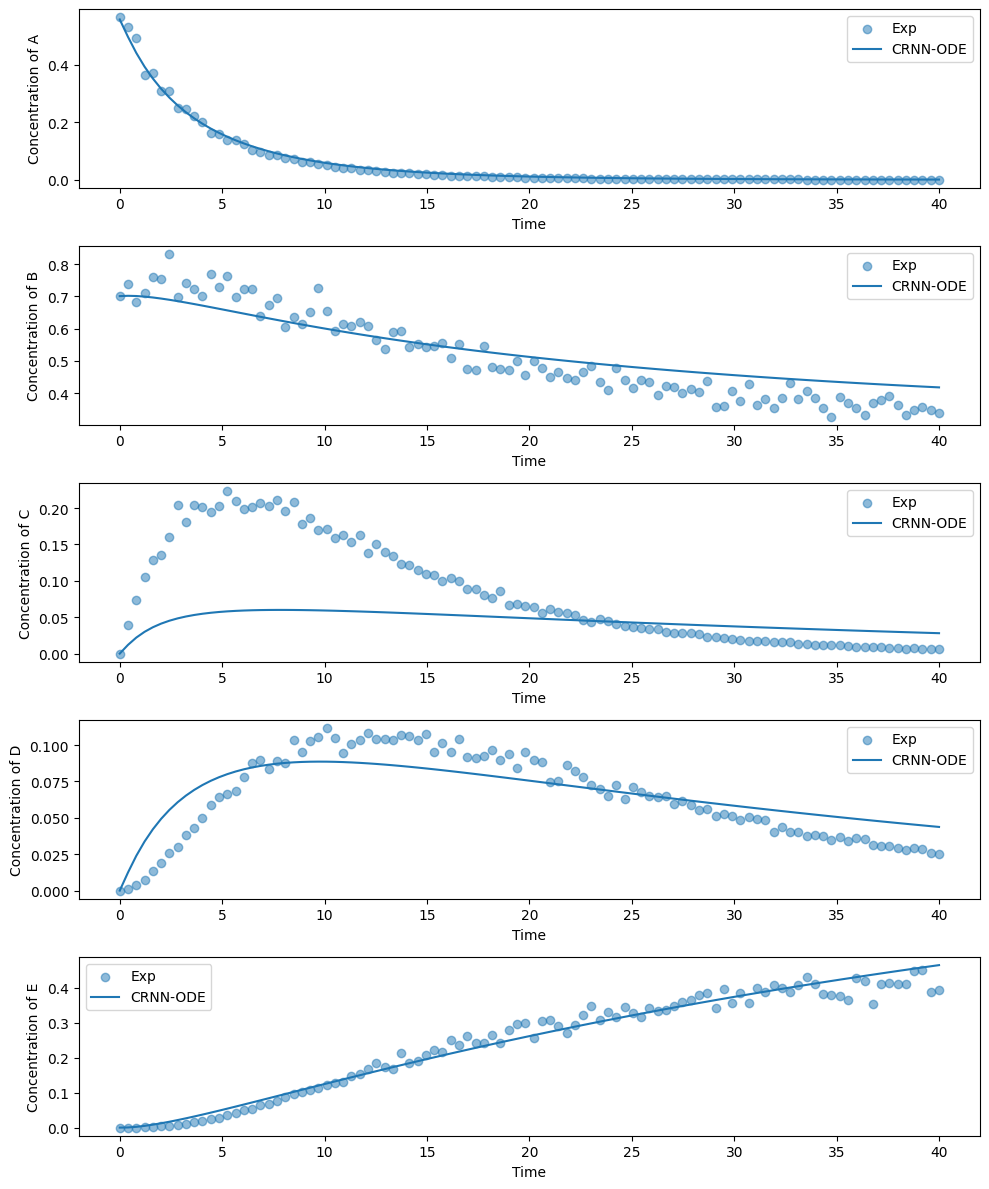

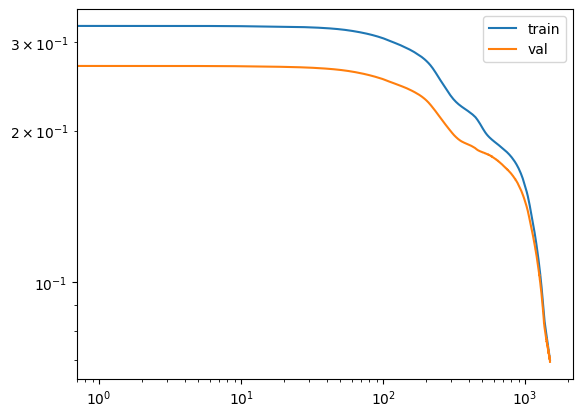

C:\Users\aksha\AppData\Local\Temp\ipykernel_15572\636344971.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'R{i+1}' for i in range(NR)])


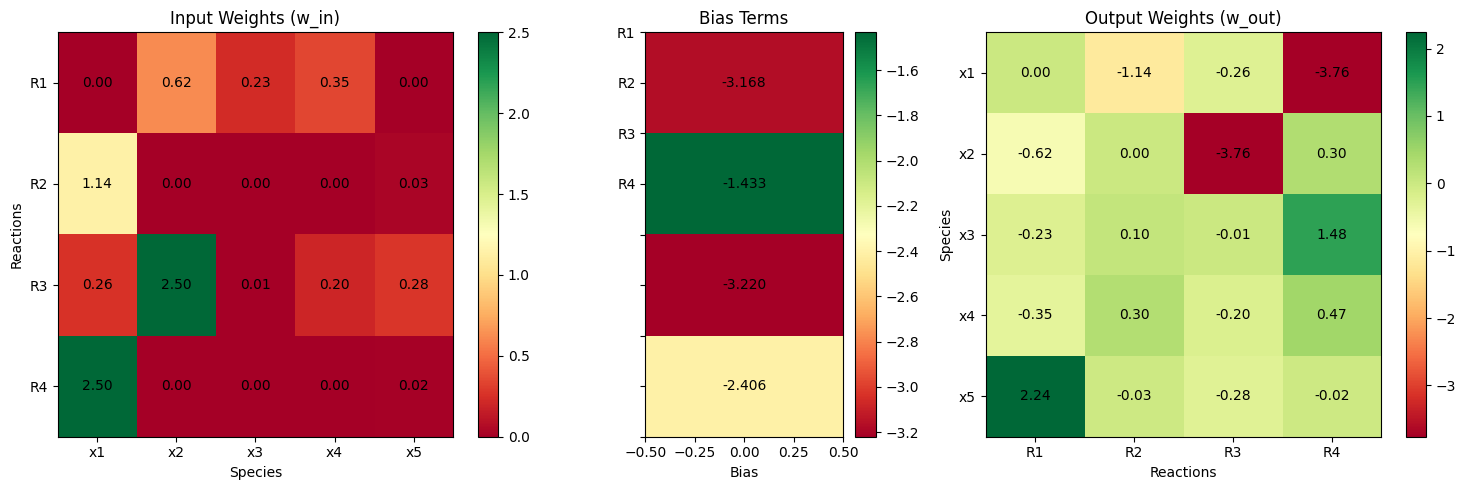

  3%|▎         | 100/3501 [17:06<14:58:03, 15.84s/it]

Epoch 1600: Train Loss = 6.1470e-02, Val Loss = 6.2425e-02


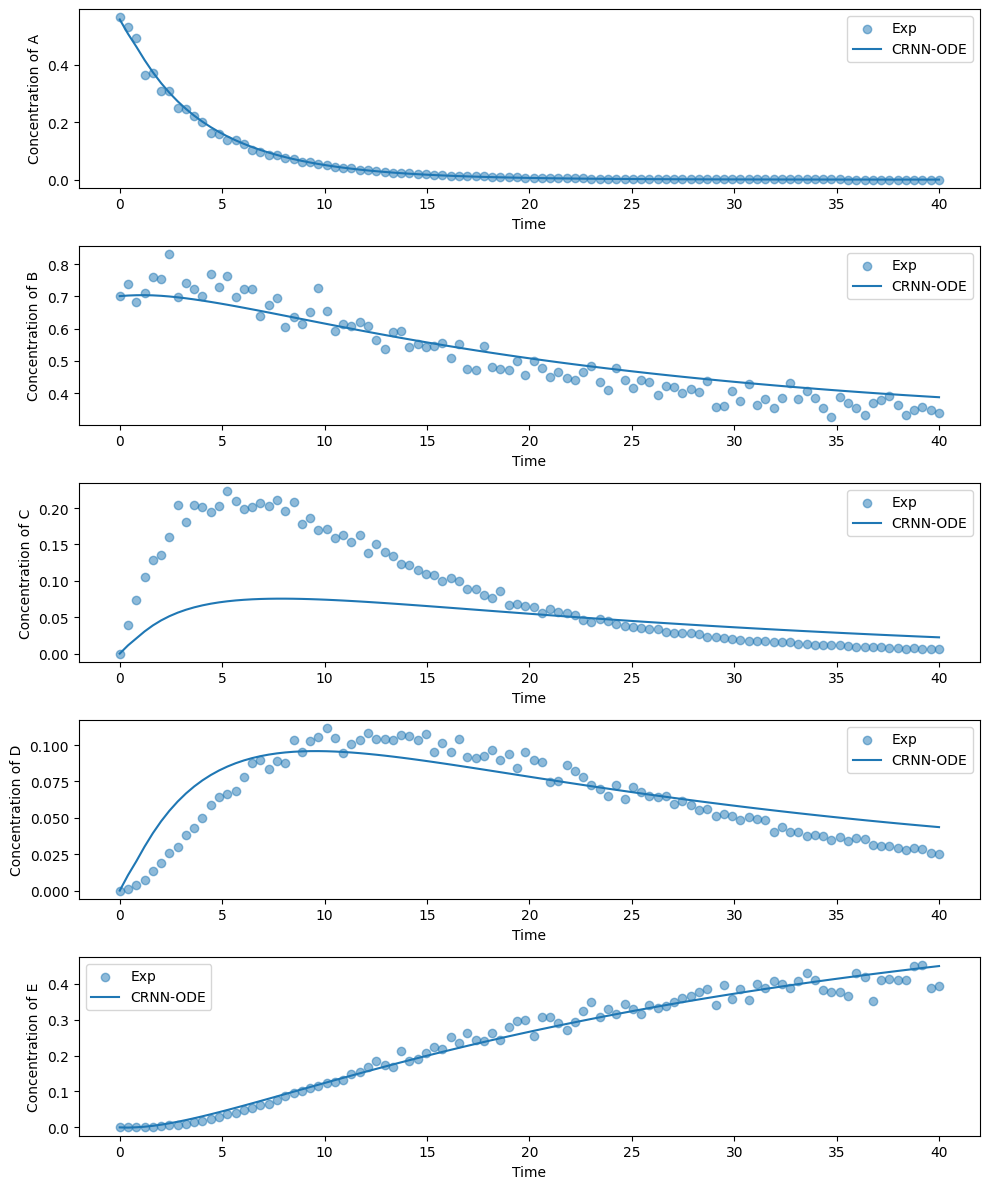

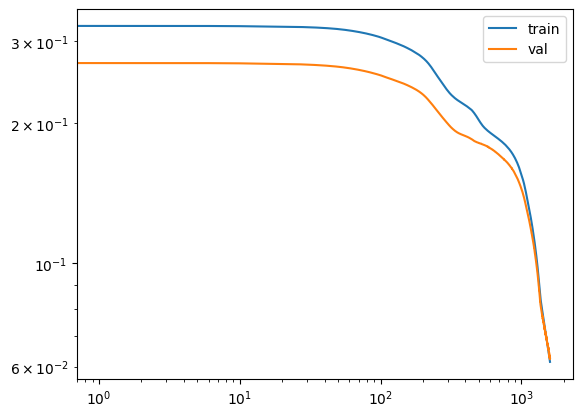

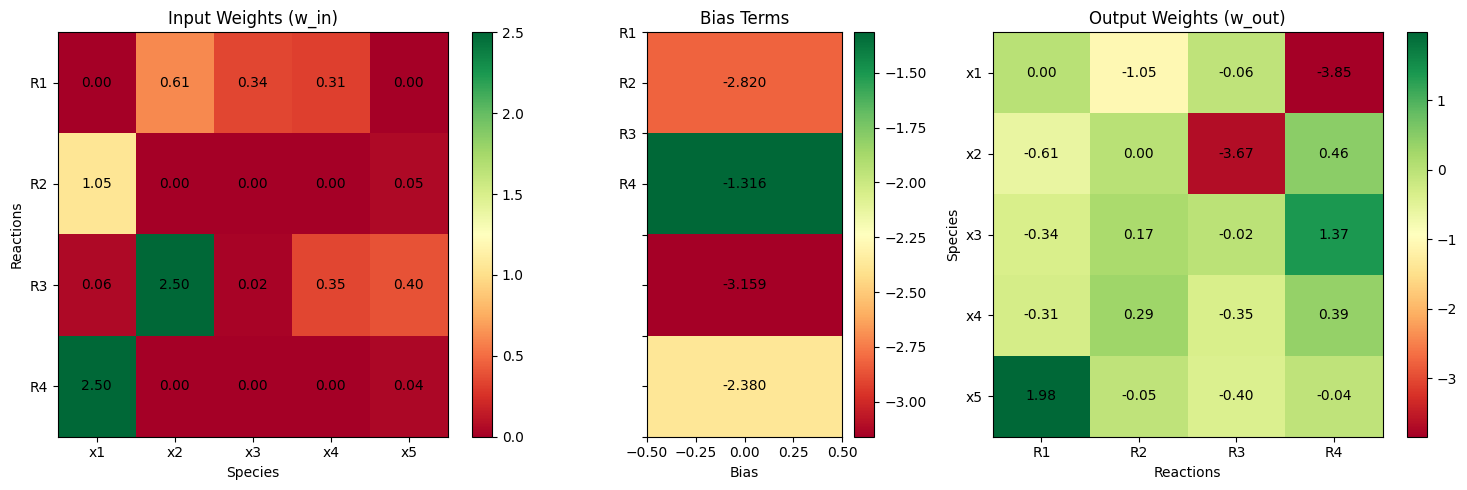

  6%|▌         | 200/3501 [41:02<12:28:47, 13.61s/it]

Epoch 1700: Train Loss = 5.3721e-02, Val Loss = 5.3443e-02


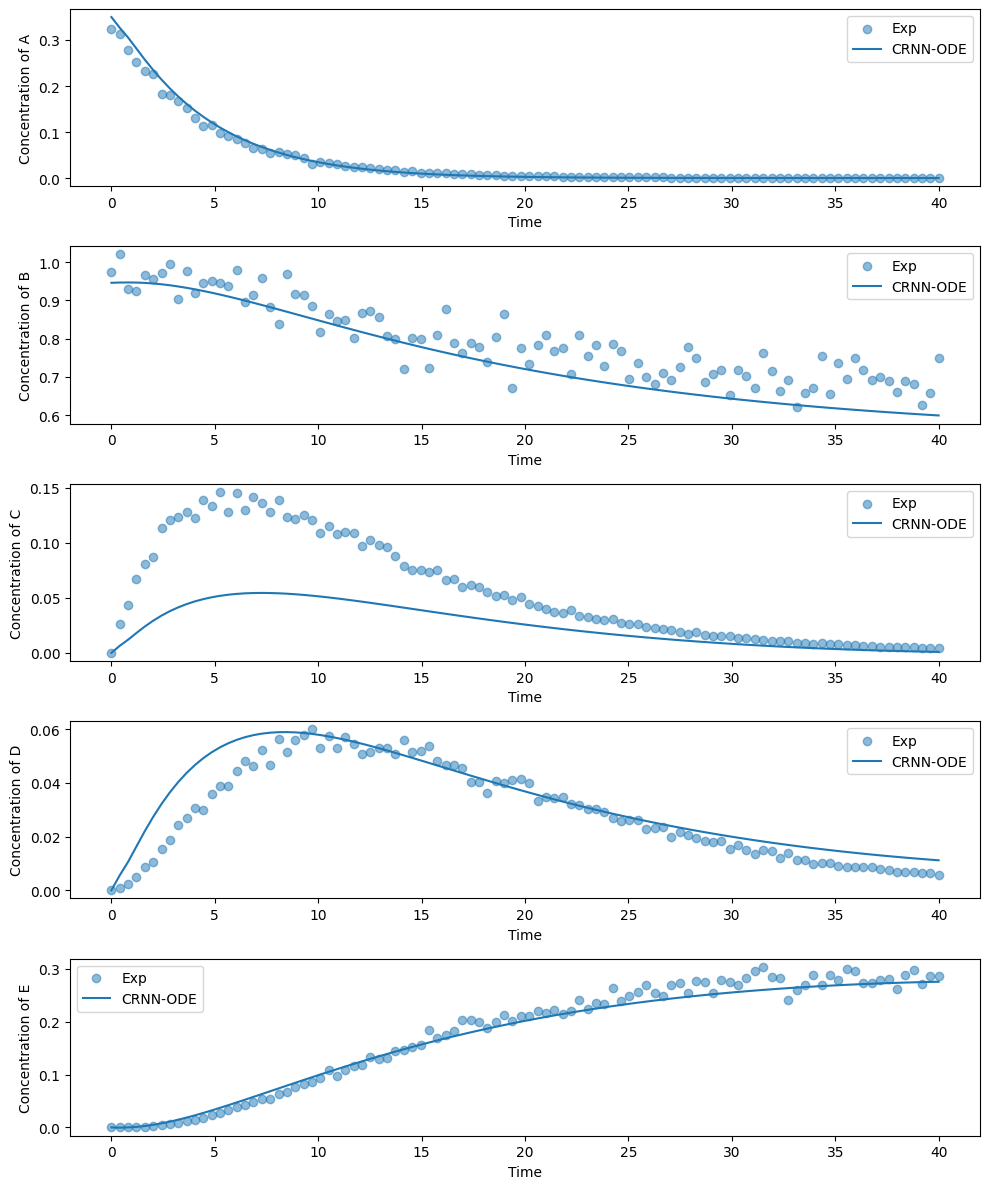

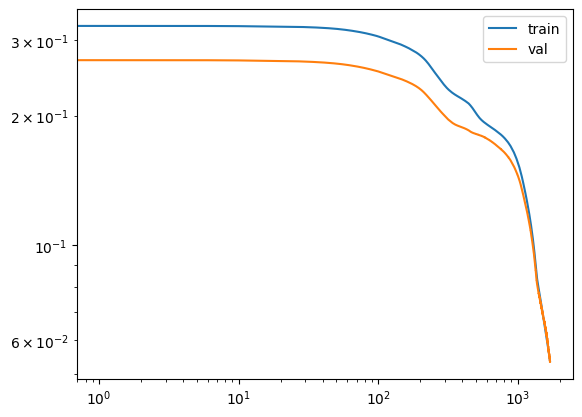

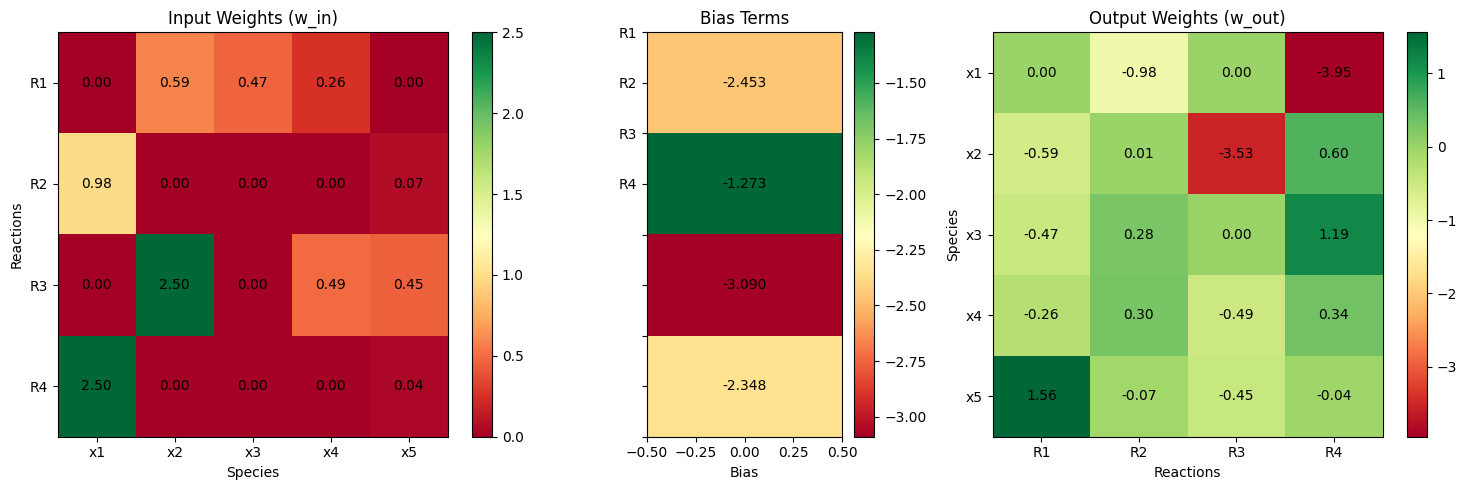

  9%|▊         | 300/3501 [1:06:21<11:02:47, 12.42s/it]

Epoch 1800: Train Loss = 4.6373e-02, Val Loss = 4.6008e-02


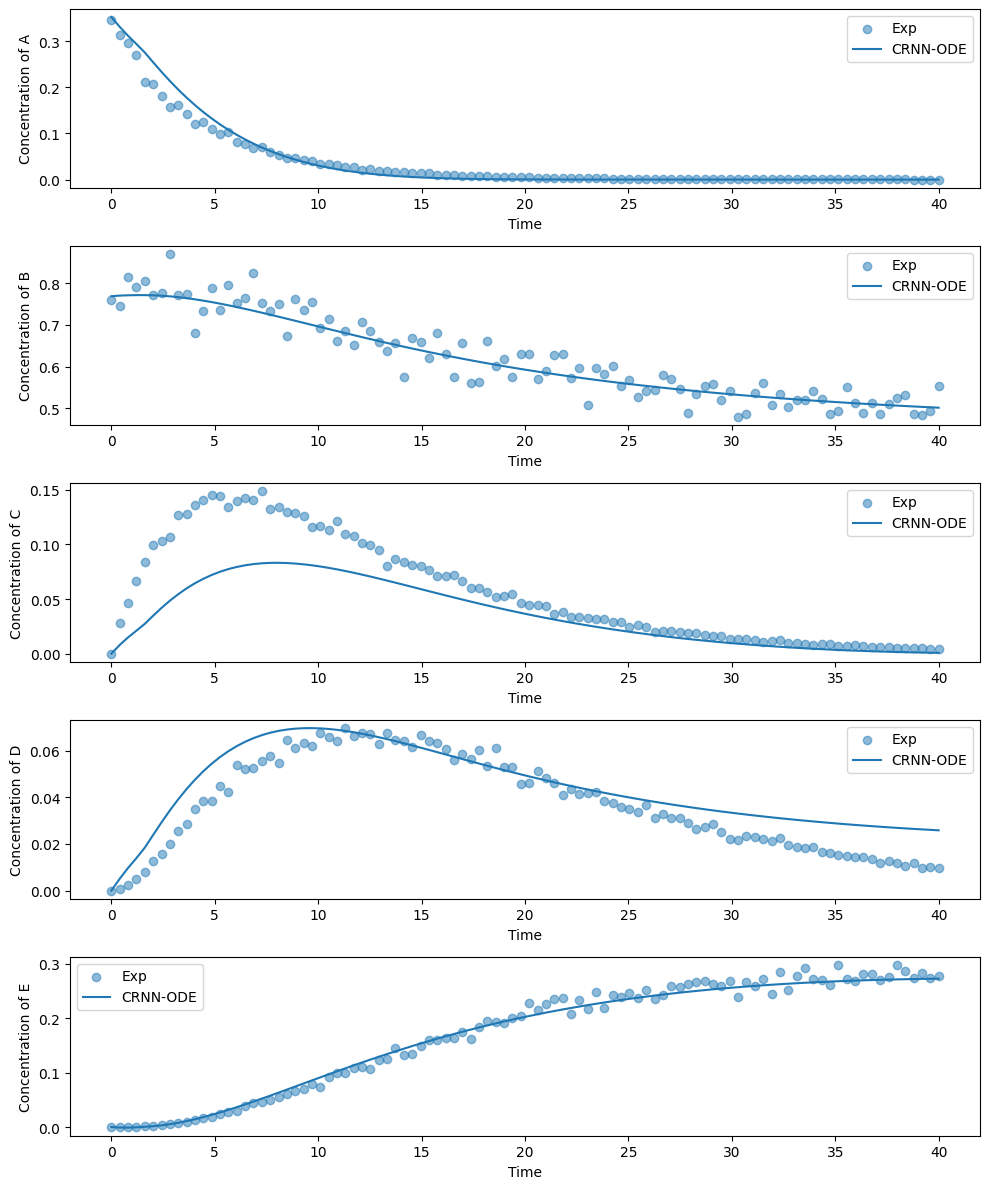

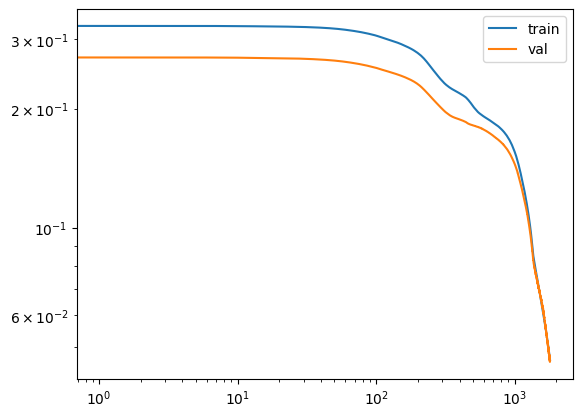

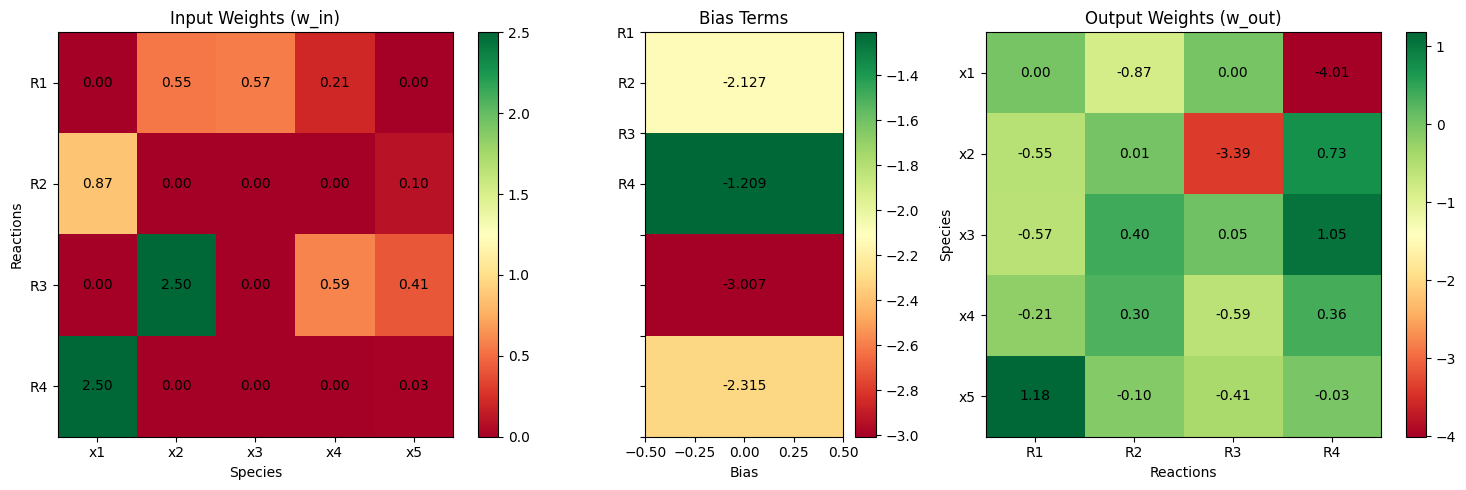

 11%|█▏        | 400/3501 [1:27:42<10:21:27, 12.02s/it]

Epoch 1900: Train Loss = 4.1208e-02, Val Loss = 4.1804e-02


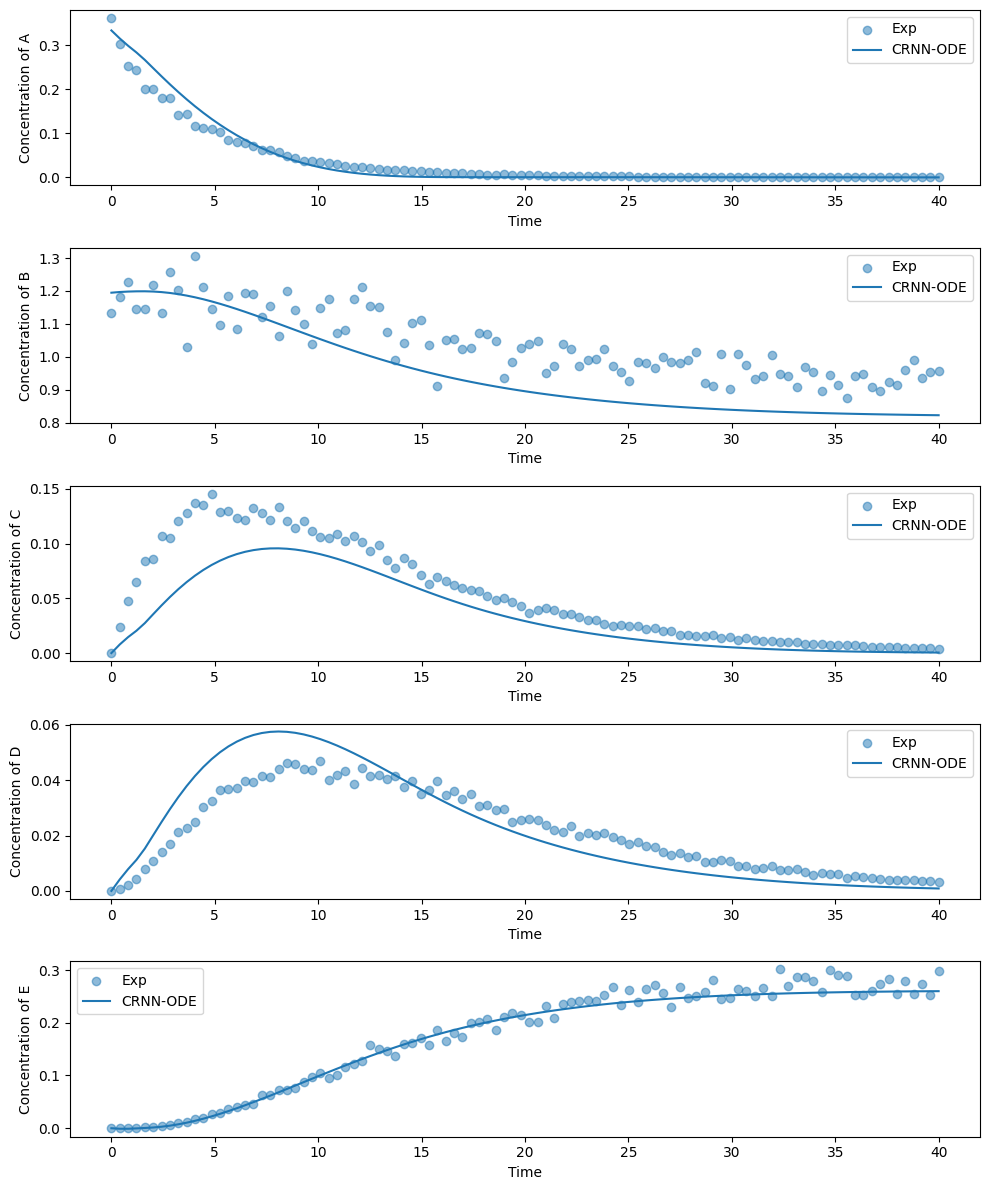

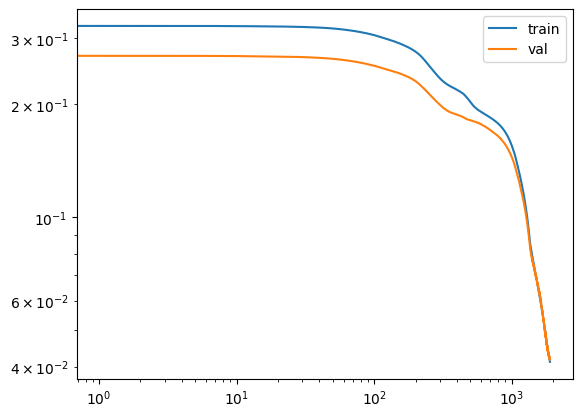

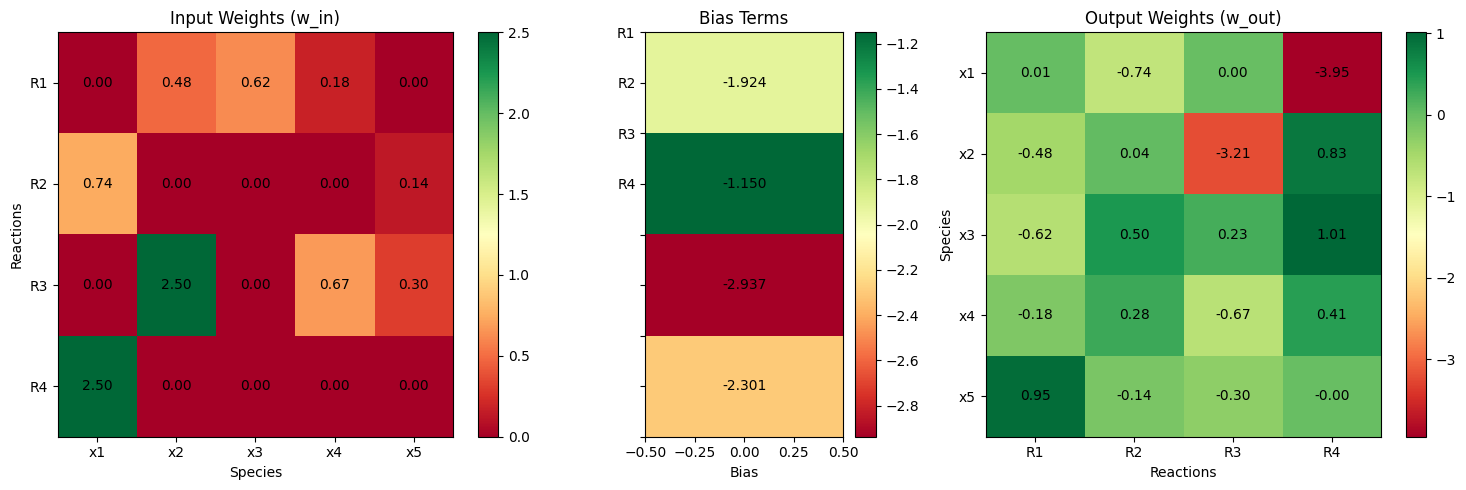

 14%|█▍        | 500/3501 [1:48:47<11:01:39, 13.23s/it]

Epoch 2000: Train Loss = 3.8890e-02, Val Loss = 4.0220e-02


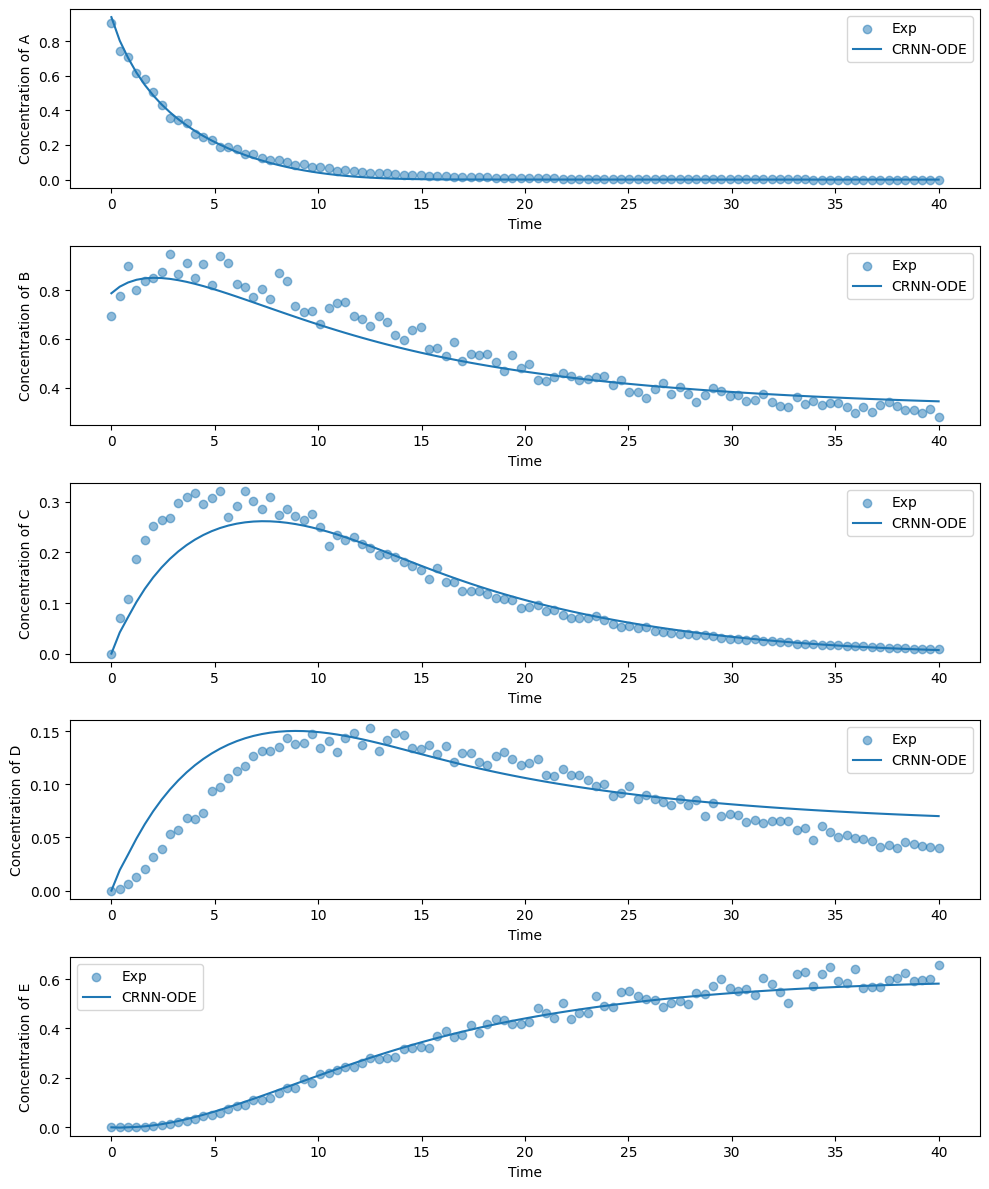

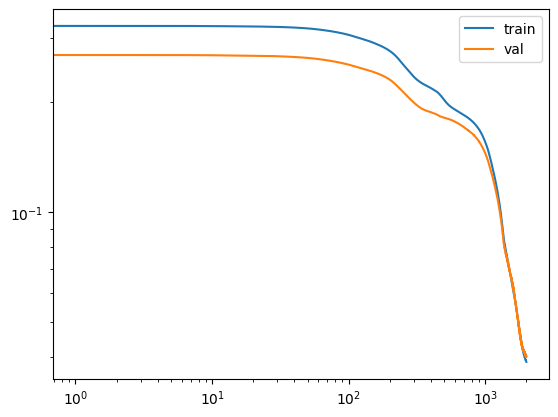

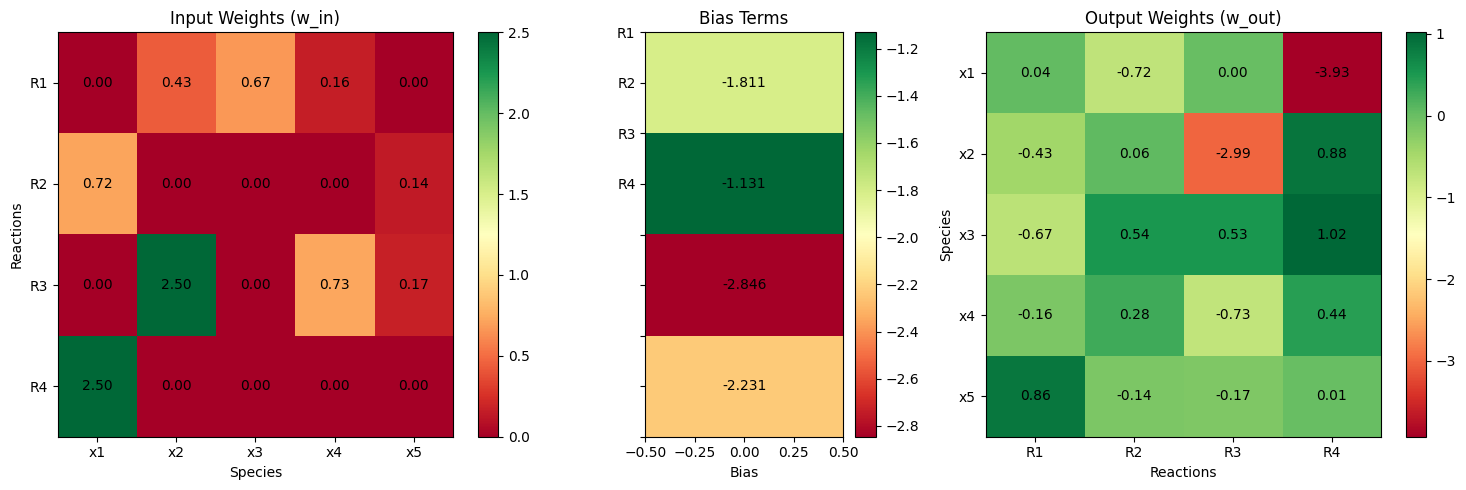

 17%|█▋        | 600/3501 [2:10:43<10:09:19, 12.60s/it]

Epoch 2100: Train Loss = 3.7277e-02, Val Loss = 3.8461e-02


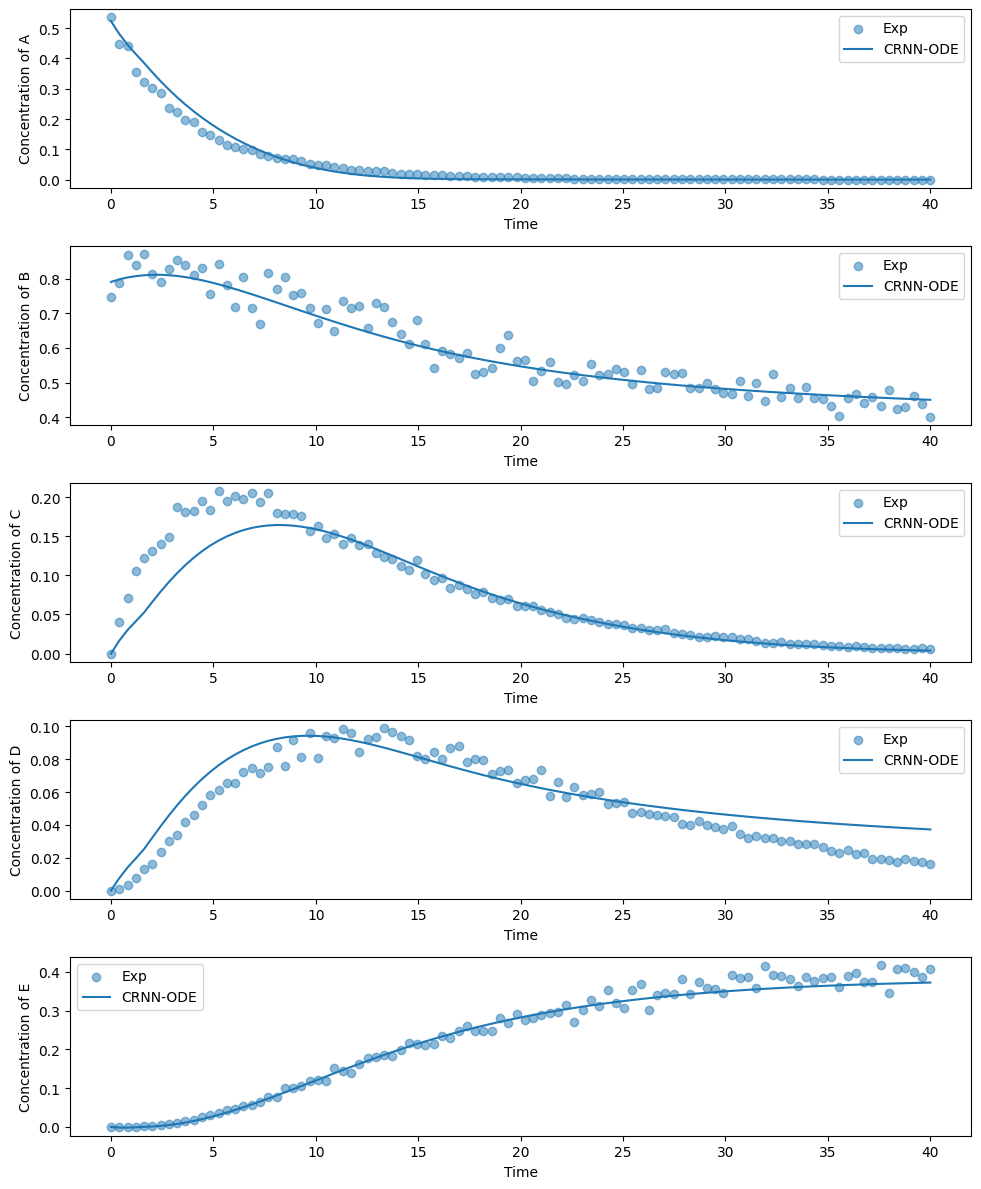

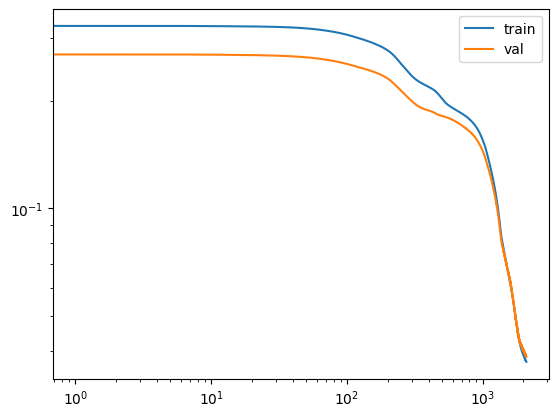

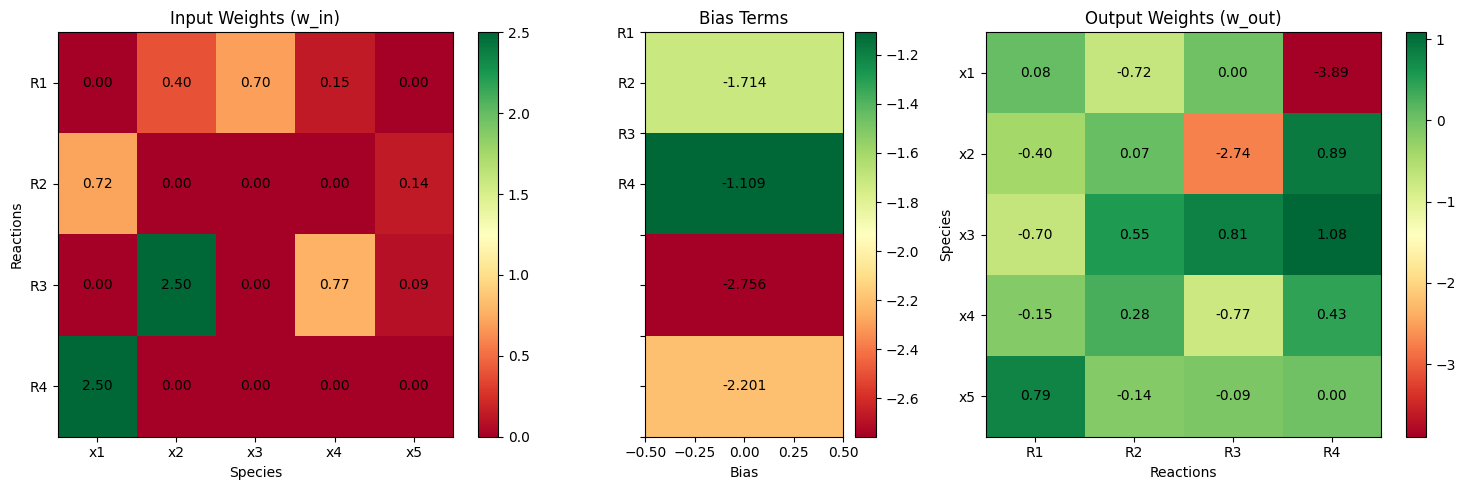

 20%|█▉        | 700/3501 [2:33:01<13:21:01, 17.16s/it]

Epoch 2200: Train Loss = 3.5933e-02, Val Loss = 3.7170e-02


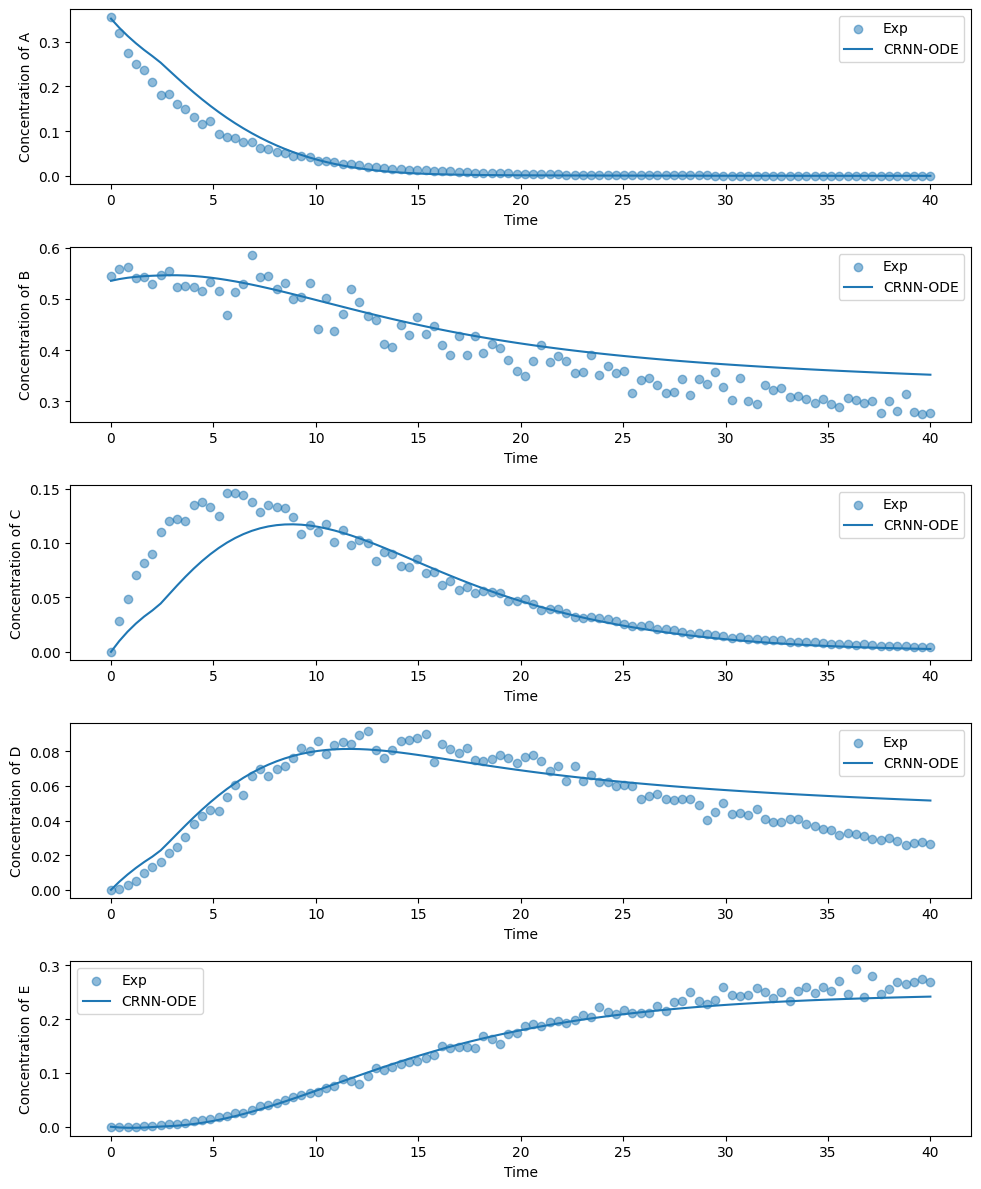

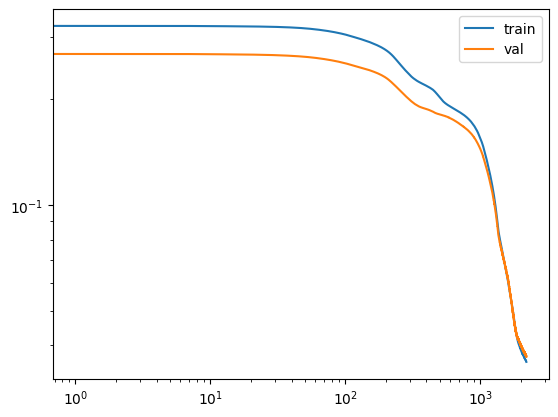

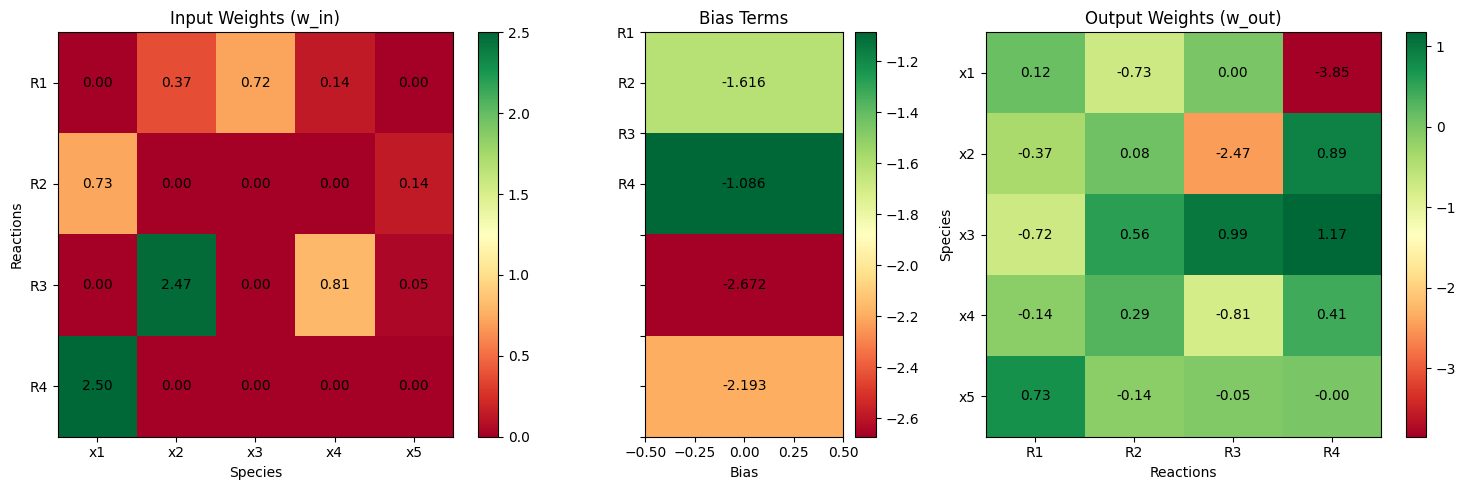

 23%|██▎       | 800/3501 [3:00:32<12:39:22, 16.87s/it]

Epoch 2300: Train Loss = 3.2173e-02, Val Loss = 3.2143e-02


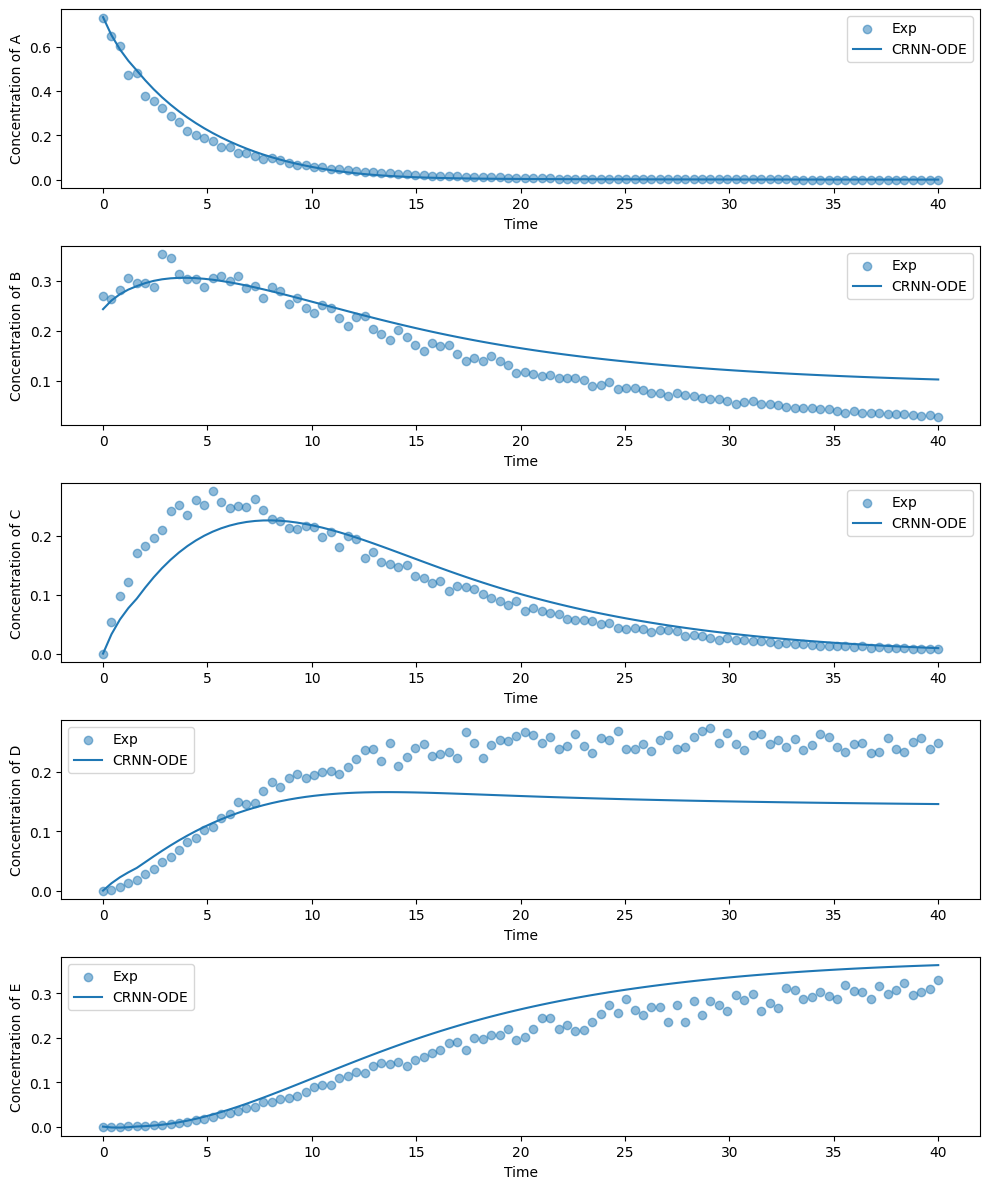

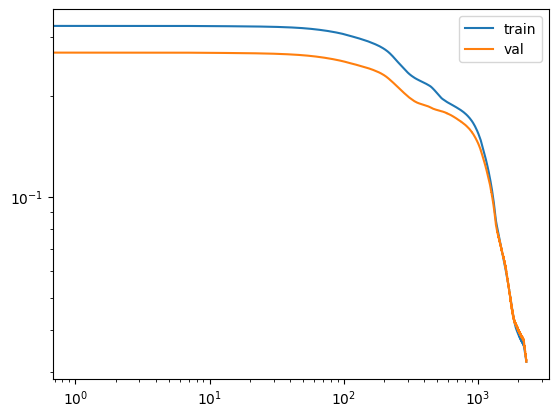

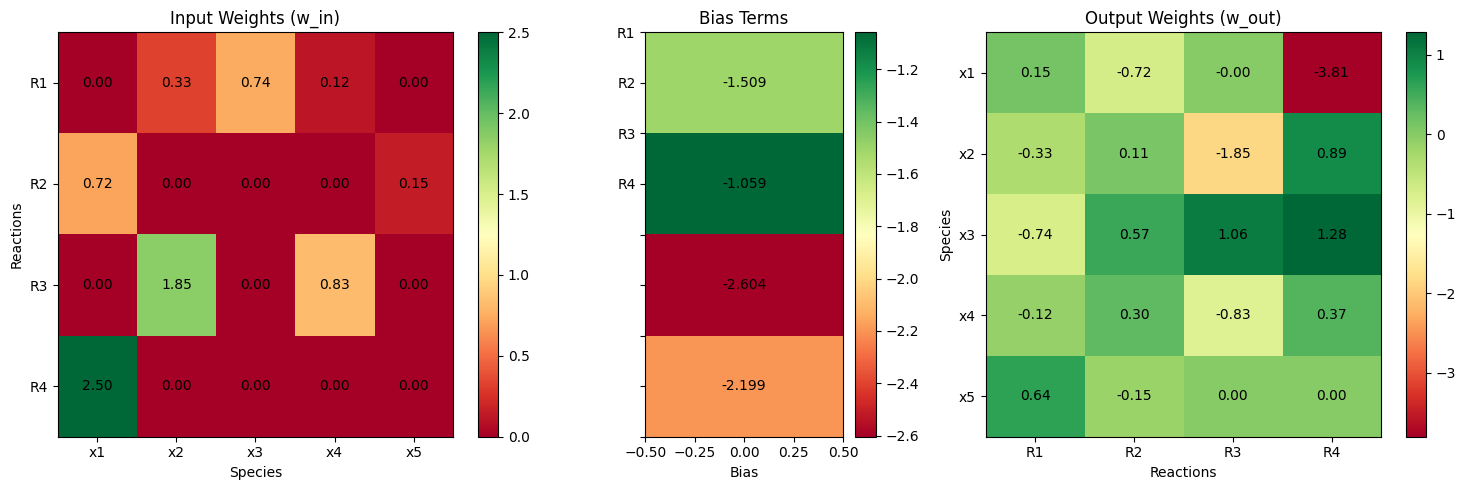

 26%|██▌       | 900/3501 [3:48:05<48:54:35, 67.70s/it]  

Epoch 2400: Train Loss = 2.8713e-02, Val Loss = 2.8129e-02


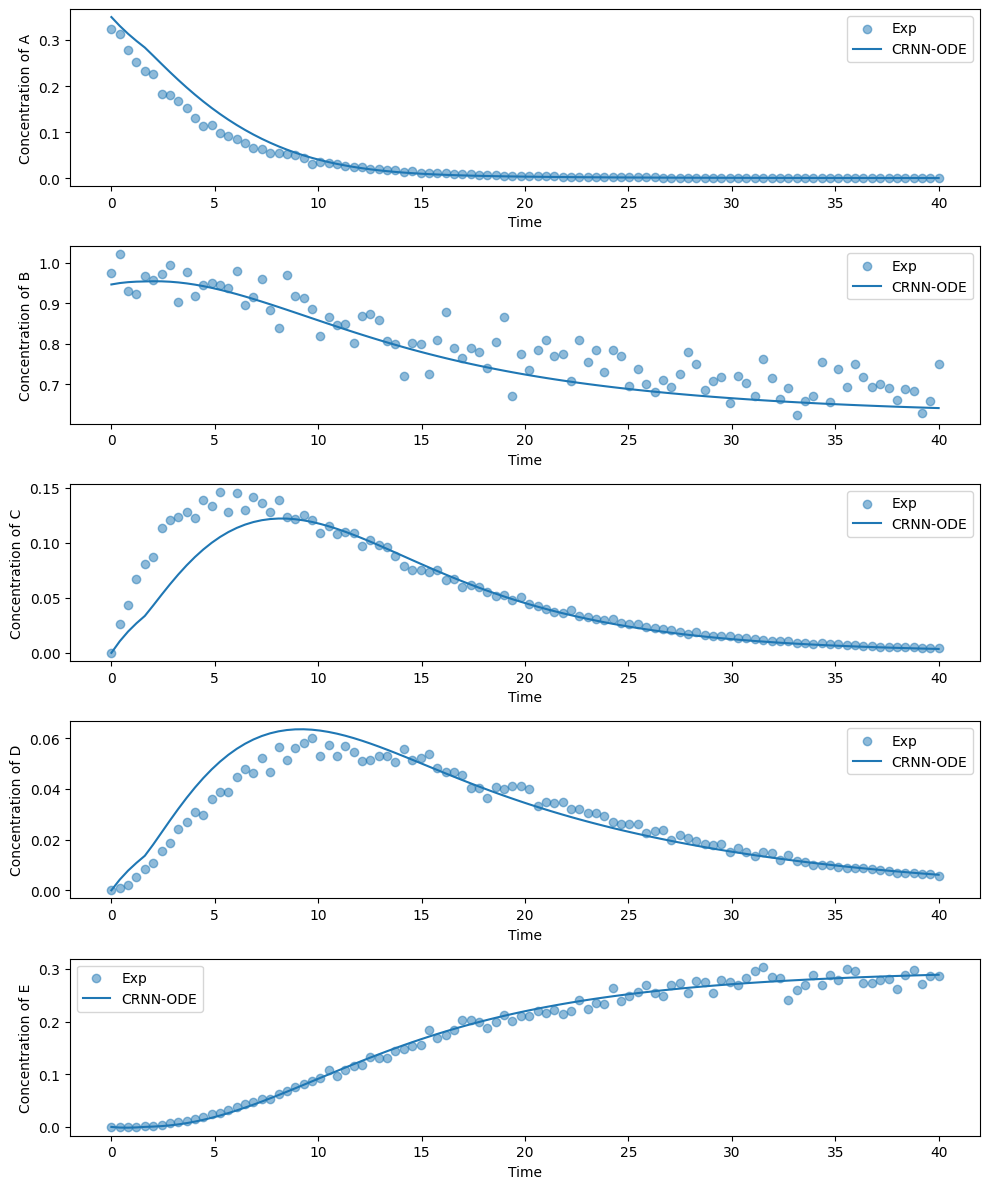

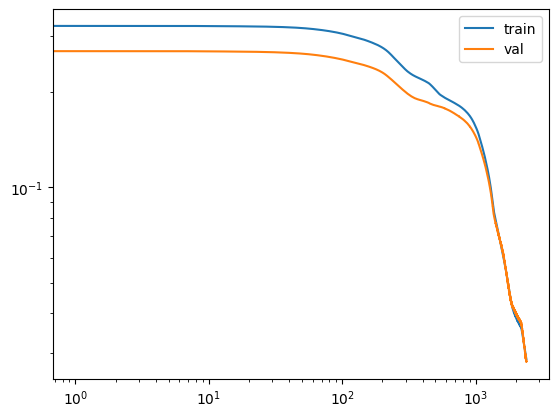

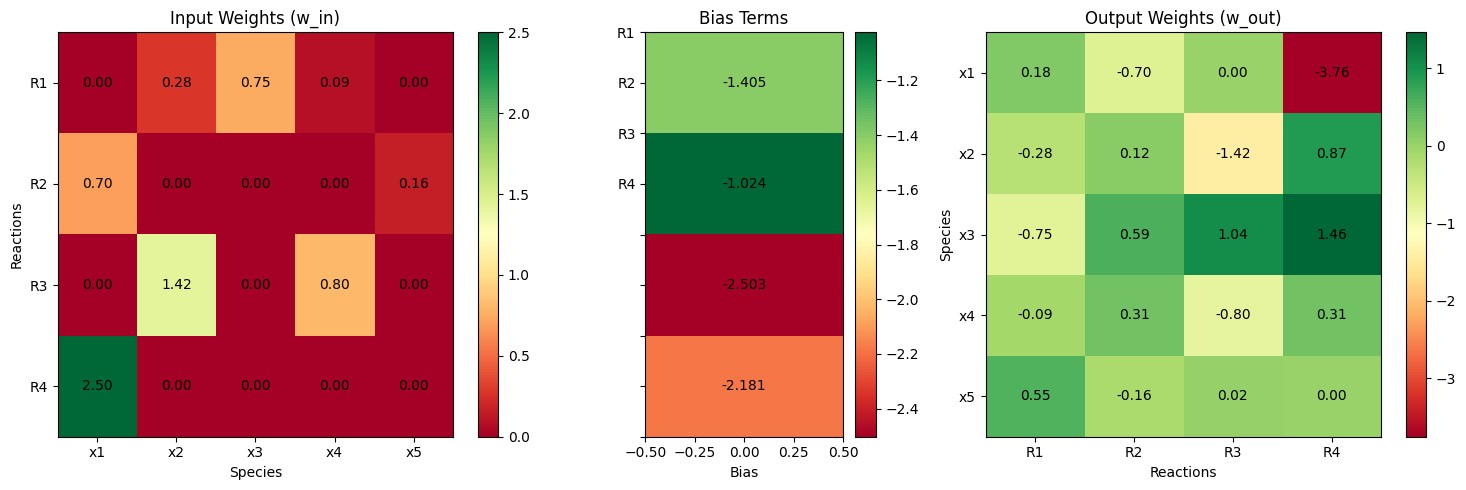

 29%|██▊       | 1000/3501 [4:14:45<12:56:11, 18.62s/it]

Epoch 2500: Train Loss = 2.5971e-02, Val Loss = 2.5357e-02


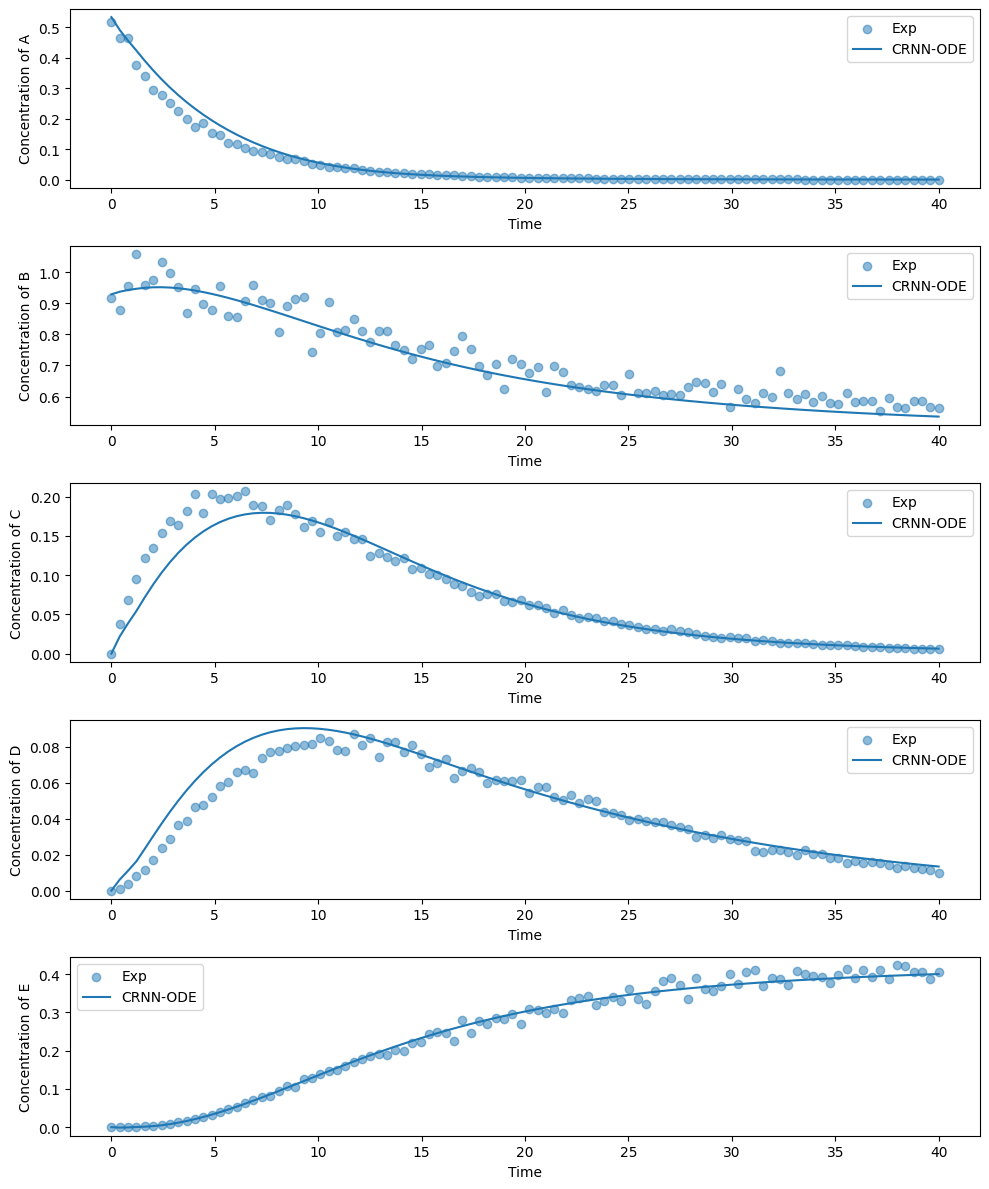

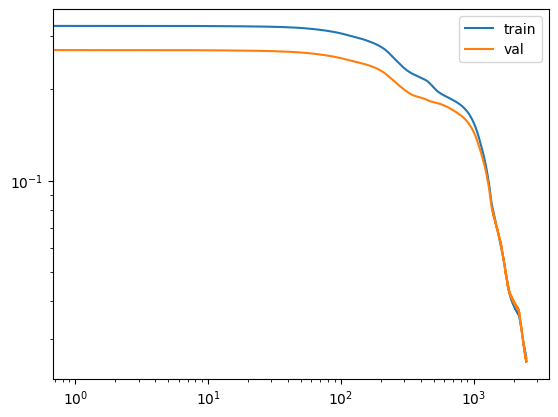

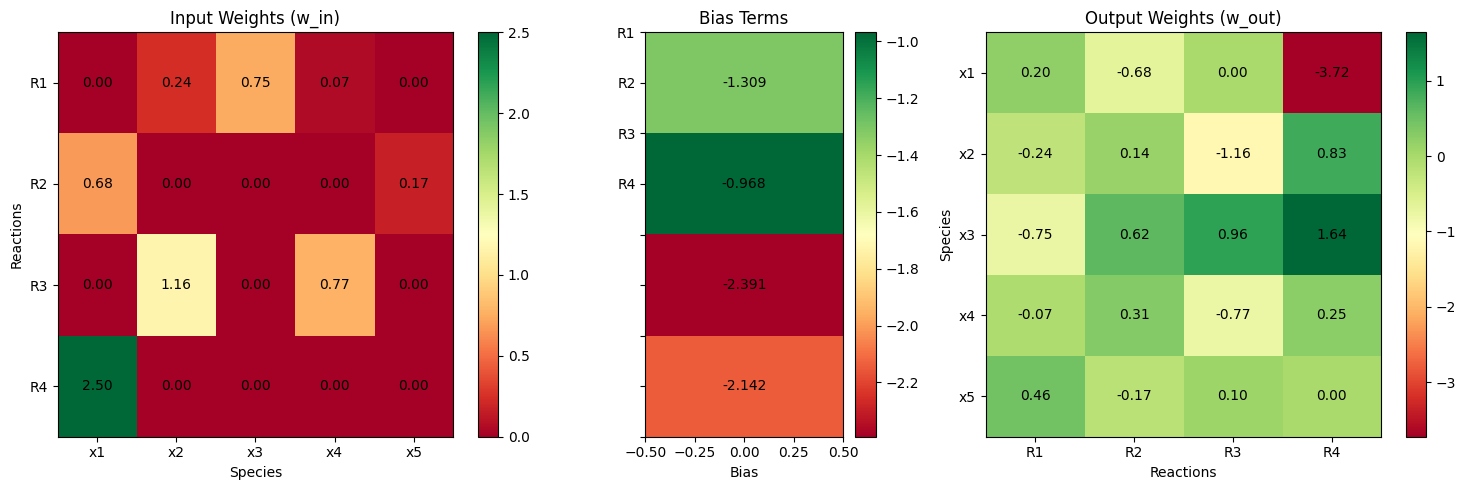

 31%|███▏      | 1100/3501 [4:39:22<9:27:30, 14.18s/it] 

Epoch 2600: Train Loss = 2.3984e-02, Val Loss = 2.3665e-02


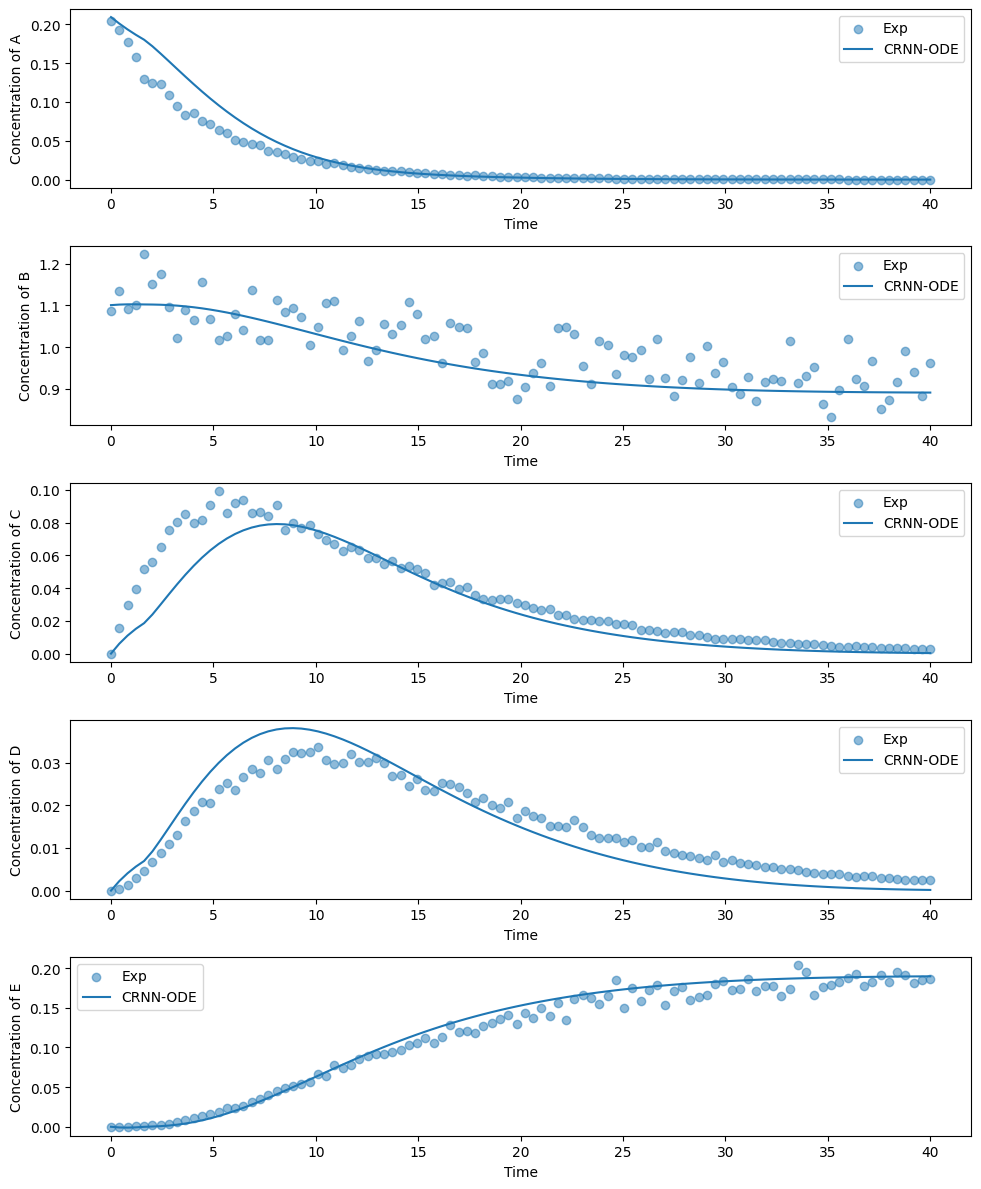

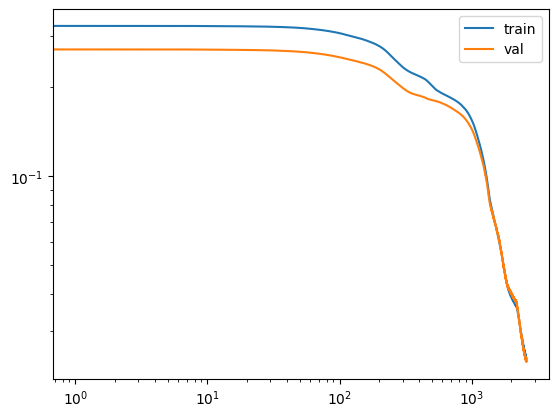

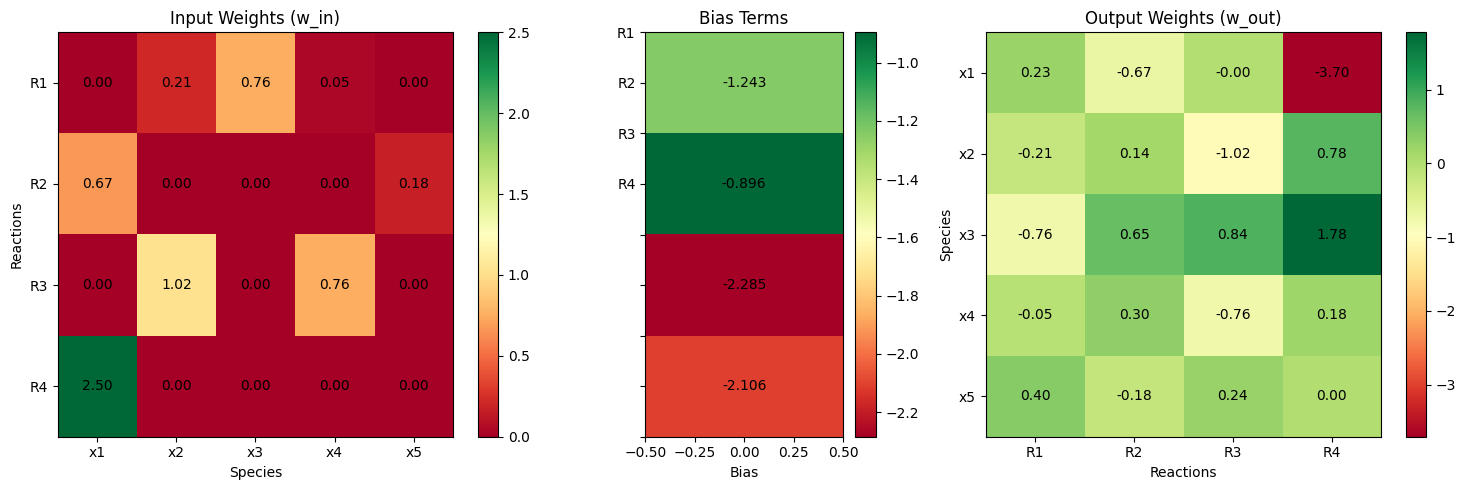

 34%|███▍      | 1200/3501 [5:04:06<9:32:49, 14.94s/it] 

Epoch 2700: Train Loss = 2.2629e-02, Val Loss = 2.2348e-02


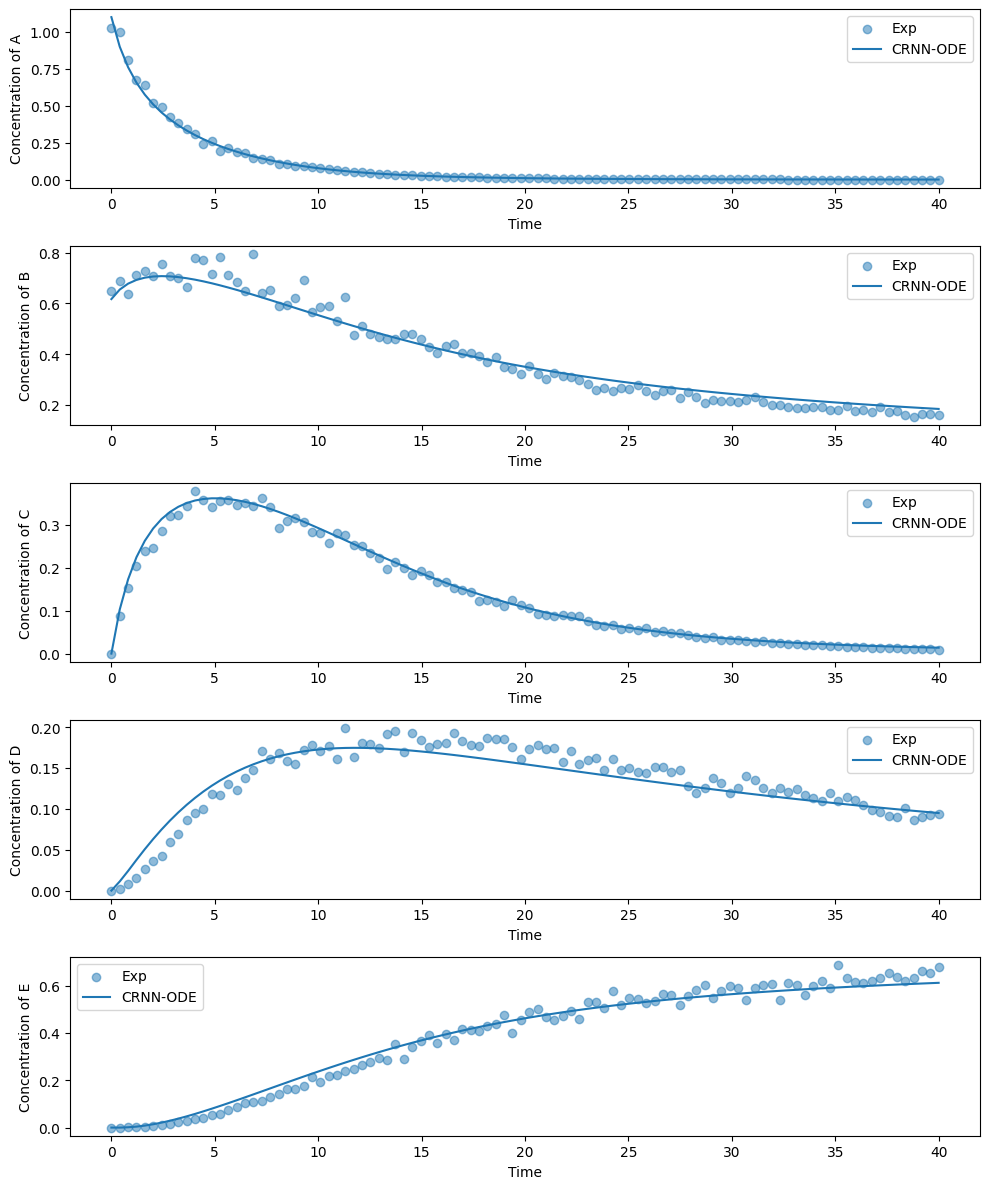

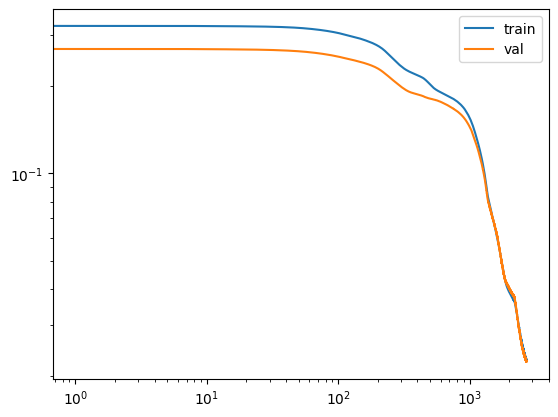

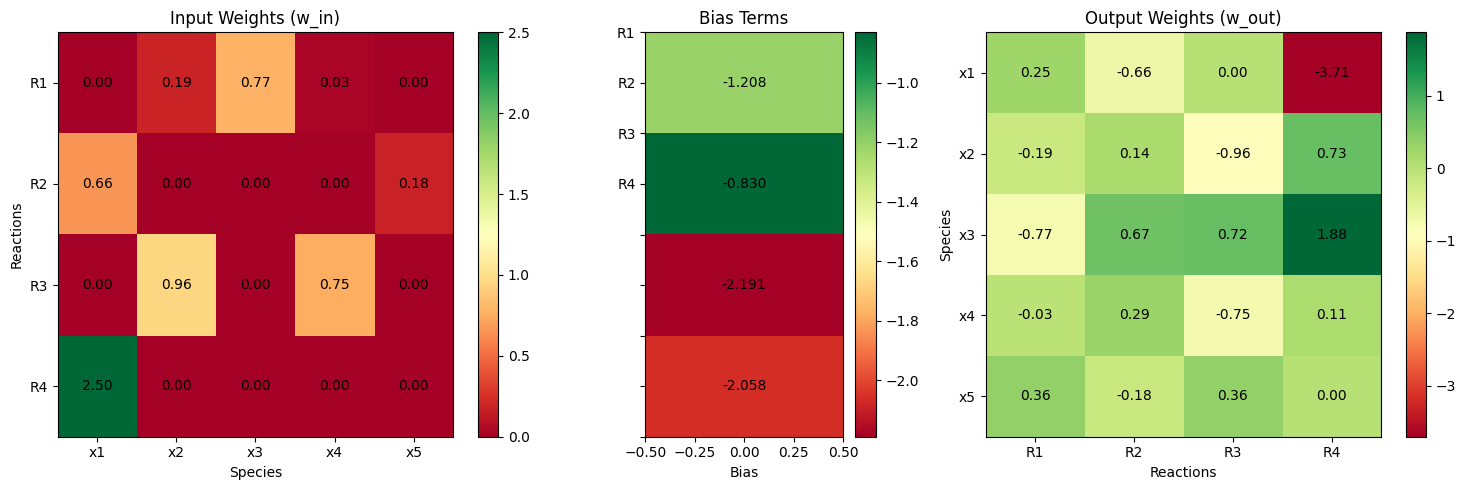

 37%|███▋      | 1300/3501 [5:30:47<11:26:34, 18.72s/it]

Epoch 2800: Train Loss = 2.1709e-02, Val Loss = 2.1628e-02


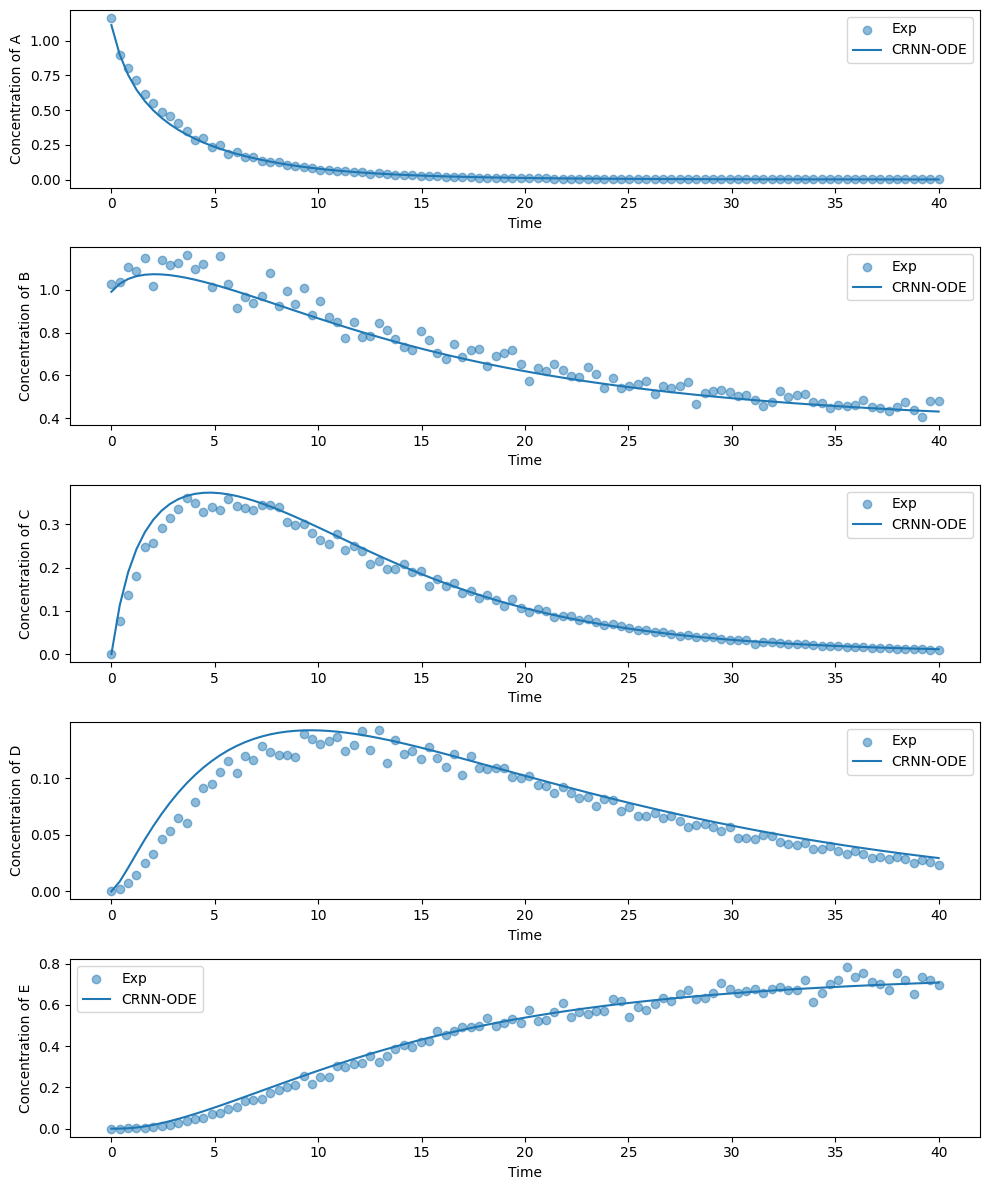

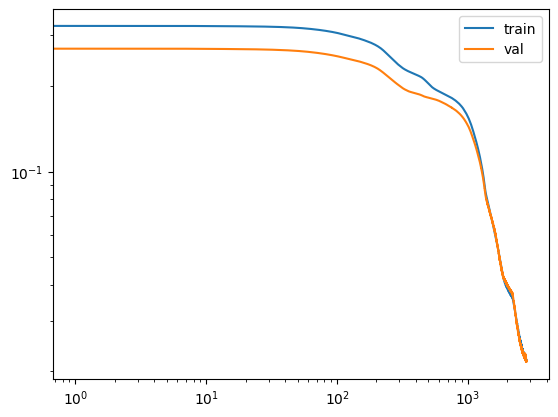

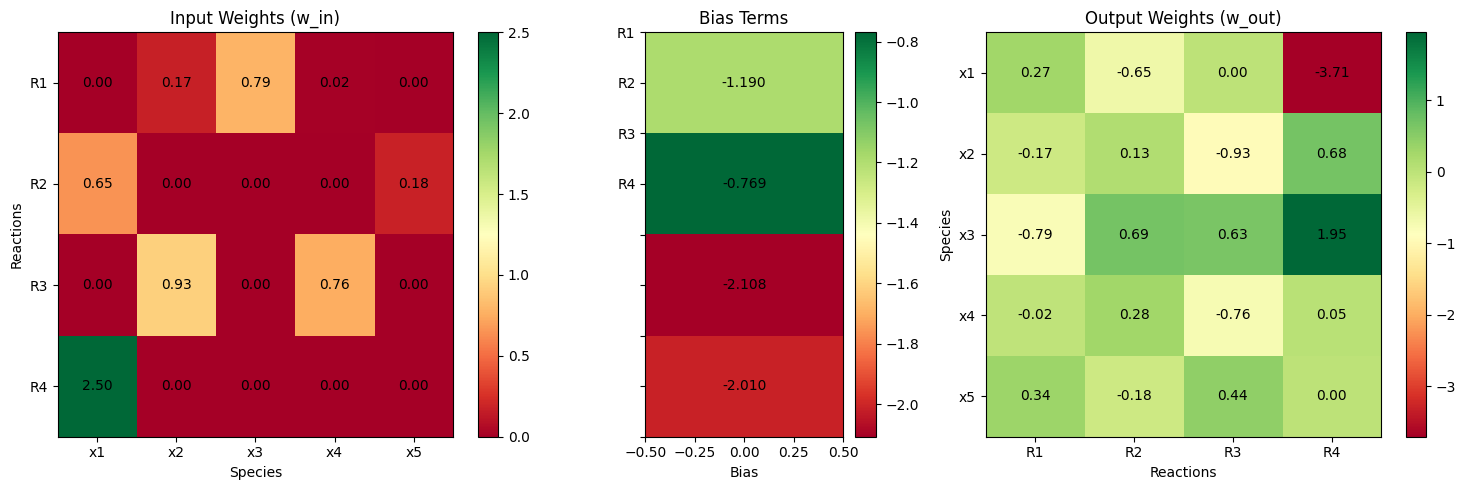

 40%|███▉      | 1400/3501 [5:58:06<9:32:48, 16.36s/it] 

Epoch 2900: Train Loss = 2.0993e-02, Val Loss = 2.1142e-02


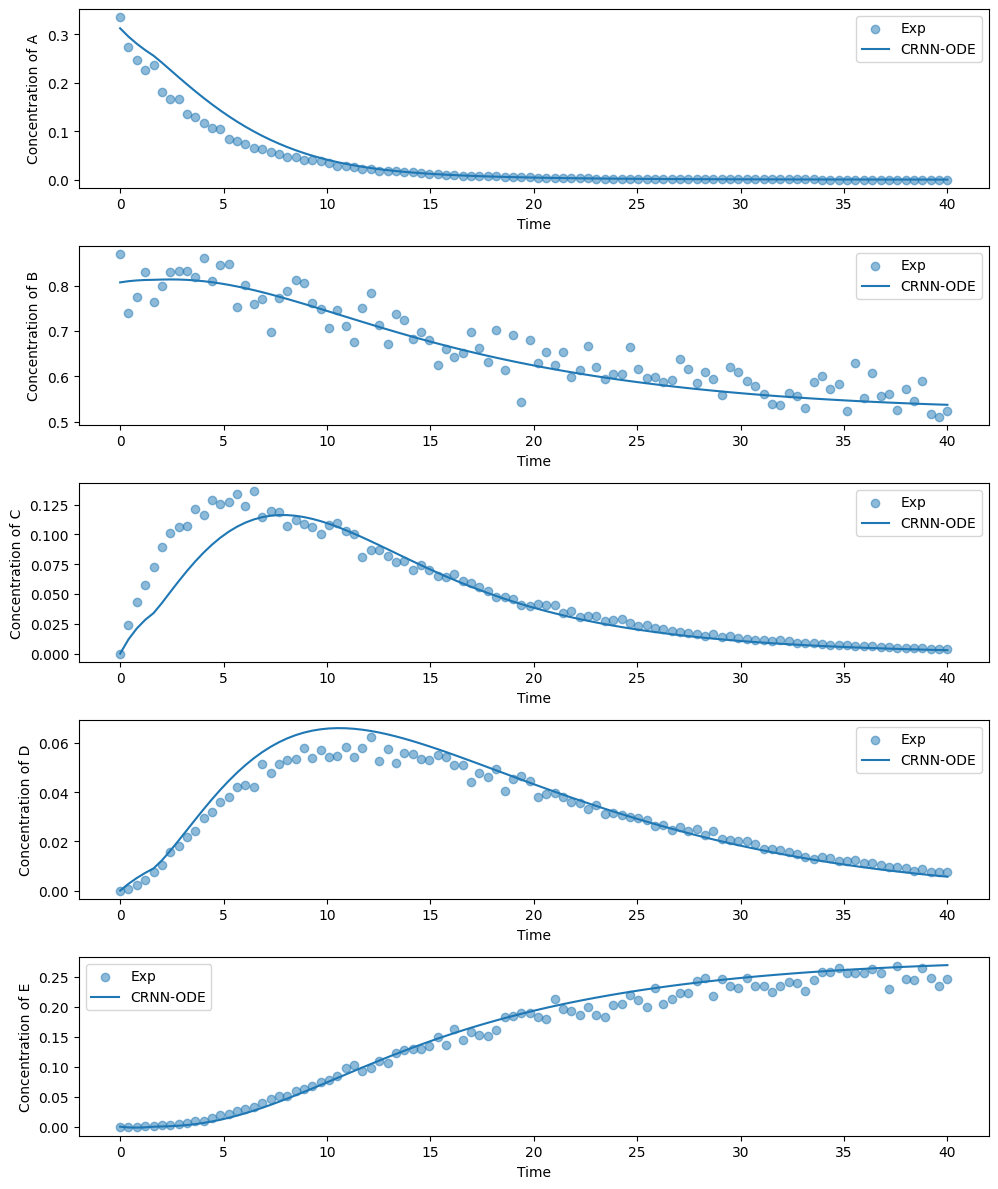

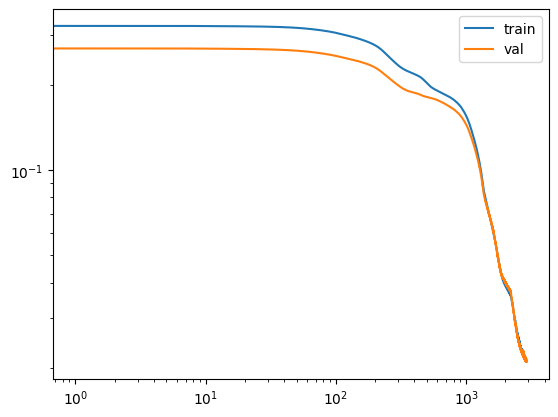

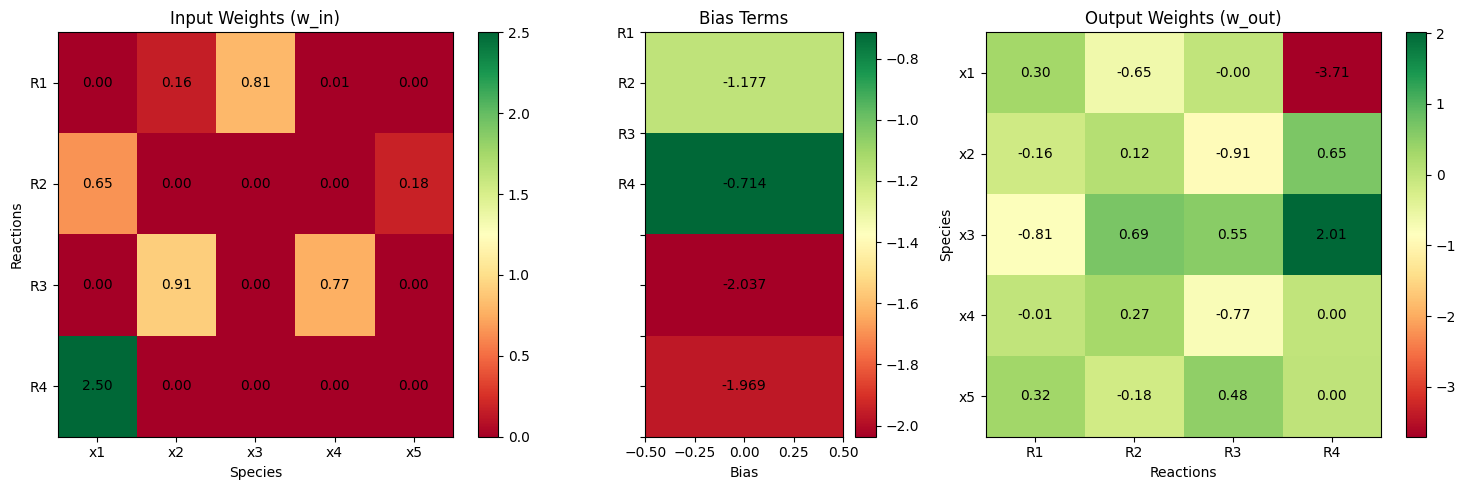

 43%|████▎     | 1500/3501 [6:25:45<9:11:34, 16.54s/it] 

Epoch 3000: Train Loss = 2.0408e-02, Val Loss = 2.0591e-02


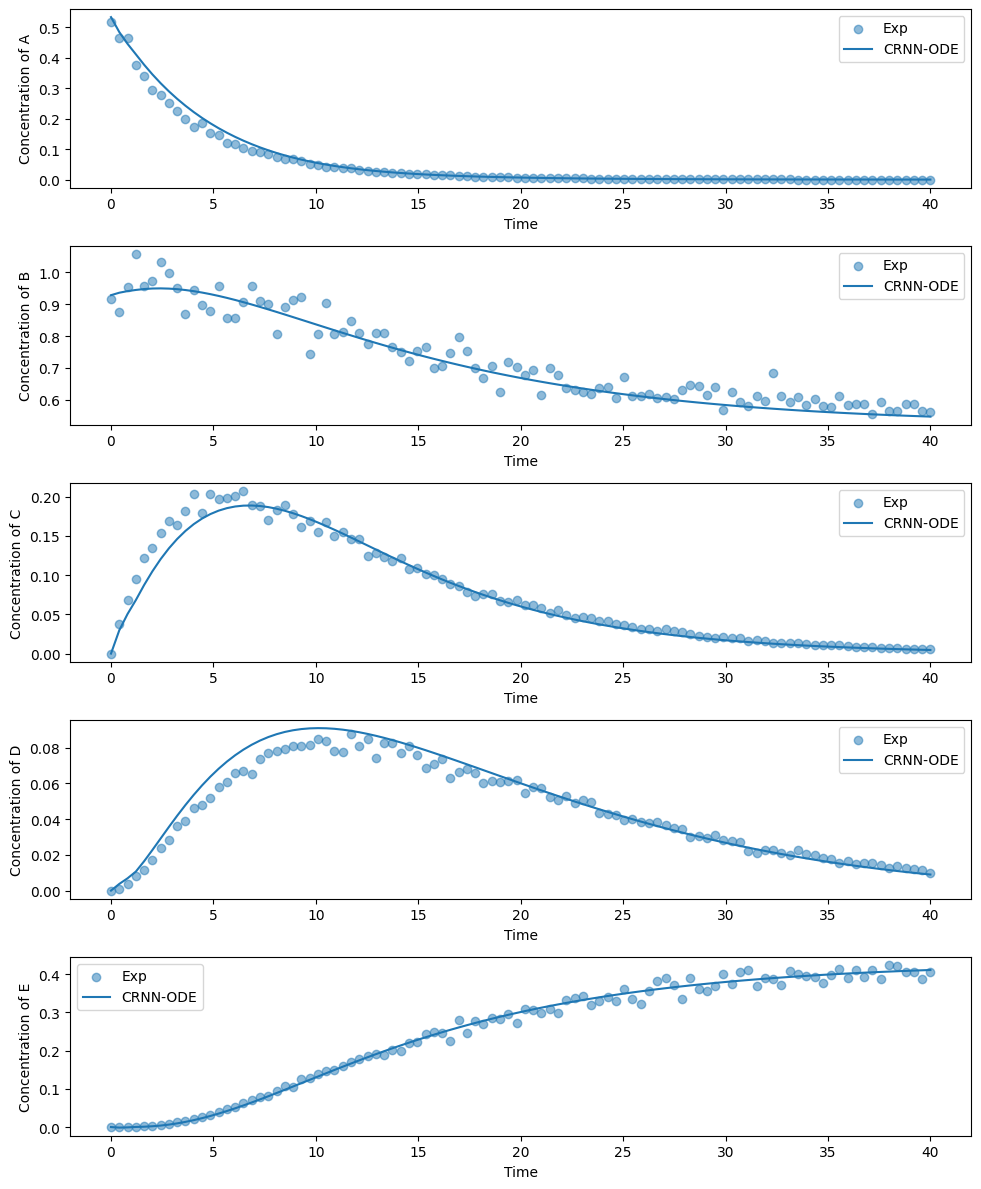

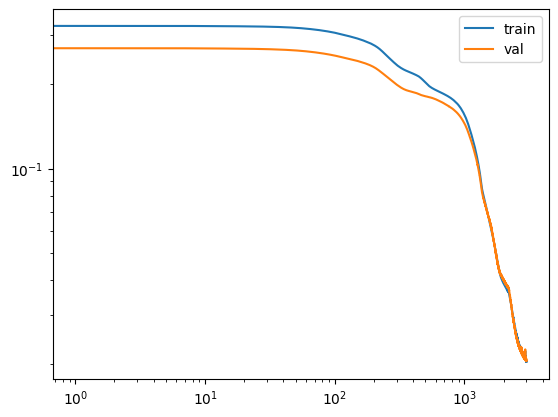

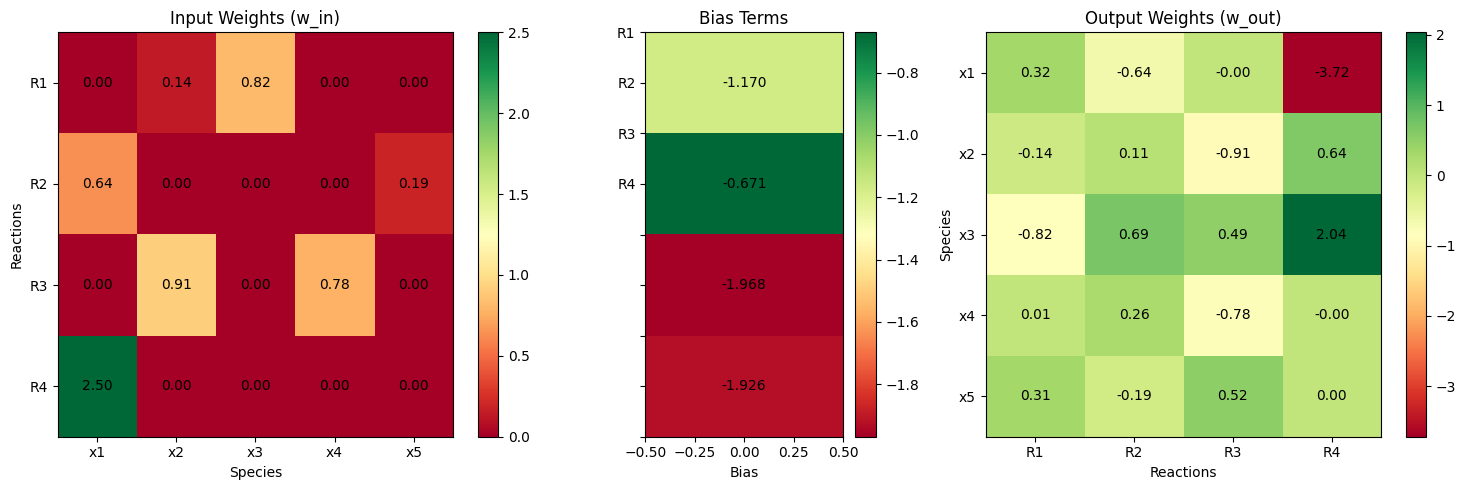

 43%|████▎     | 1512/3501 [6:29:13<9:29:18, 17.17s/it]

In [ ]:
!pip install torch torchdiffeq
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
import torchdiffeq
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import os
import pickle

# Set random seeds for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

# Arguments
IS_RESTART = True
P_CUTOFF = 0.0
N_EPOCH = 5000
N_PLOT = 100
LEARNING_RATE = 0.0005
DATASIZE = 100
TSTEP = 0.4
N_EXP_TRAIN = 20
N_EXP_TEST = 10
N_EXP = N_EXP_TRAIN + N_EXP_TEST
NOISE = 5e-2
NS = 5  # number of species
NR = 4  # number of reactions
K = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

LB = 1e-5
UB = 10.0

def true_ode_func(t, y, k):
    """The true ODE function representing the chemical reaction system"""
    y = torch.tensor(y, dtype=torch.float32)
    dydt = torch.zeros_like(y)

    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]

    return dydt.numpy()

def max_min(ode_data):
    """Calculate range of values for each species"""
    return np.max(ode_data, axis=1) - np.min(ode_data, axis=1) + LB

# Generate dataset
u0_list = np.random.rand(N_EXP, NS).astype(np.float32)
u0_list[:, 0:2] += 2e-1
u0_list[:, 2:] = 0.0

tspan = [0.0, DATASIZE * TSTEP]
tsteps = np.linspace(tspan[0], tspan[1], DATASIZE)
ode_data_list = np.zeros((N_EXP, NS, DATASIZE), dtype=np.float32)
std_list = []

# Generate training data
for i in range(N_EXP):
    u0 = u0_list[i]
    sol = solve_ivp(true_ode_func, tspan, u0, t_eval=tsteps, args=(K,), method='RK45')
    ode_data = sol.y
    ode_data += np.random.randn(*ode_data.shape) * ode_data * NOISE
    ode_data_list[i] = ode_data
    std_list.append(max_min(ode_data))

# Stack std_list and compute max for each species
std_array = np.stack(std_list, axis=0)
y_std = np.max(std_array, axis=0)
y_std = torch.tensor(y_std, dtype=torch.float32)

class CRNN(nn.Module):
    def __init__(self, ns, nr):
        super(CRNN, self).__init__()
        self.ns = ns
        self.nr = nr
        self.b0 = -10.0

        # Initialize parameters
        self.w_b = nn.Parameter(torch.randn(nr) + self.b0)
        self.w_out = nn.Parameter(torch.randn(ns, nr) * 0.1)

    def forward(self, t, y):
        y = torch.clamp(y, min=LB, max=UB)
        w_in = torch.clamp(-self.w_out, min=0, max=2.5)

        w_in_x = torch.matmul(w_in.t(), torch.log(y))
        dydt = torch.matmul(self.w_out, torch.exp(w_in_x + self.w_b))

        return dydt

def predict_neural_ode(model, u0, tsteps):
    u0 = torch.tensor(u0, dtype=torch.float32)
    t = torch.tensor(tsteps, dtype=torch.float32)

    pred = torchdiffeq.odeint(model, u0, t, method='dopri5')
    return torch.clamp(pred, -UB, UB)

def loss_neural_ode(model, i_exp):
    pred = predict_neural_ode(model, u0_list[i_exp], tsteps)
    target = torch.tensor(ode_data_list[i_exp], dtype=torch.float32)

    pred = pred.t()
    y_std_expanded = y_std.view(-1, 1)

    loss = torch.mean(torch.abs((target - pred) / y_std_expanded))
    return loss

def plot_results(model, i_exp, species=["A", "B", "C", "D", "E"]):
    ode_data = ode_data_list[i_exp]
    pred = predict_neural_ode(model, u0_list[i_exp], tsteps).detach().numpy()

    fig, axes = plt.subplots(NS, 1, figsize=(10, 12))
    for i in range(NS):
        axes[i].scatter(tsteps, ode_data[i], alpha=0.5, label='Exp')
        axes[i].plot(tsteps, pred[:, i], label='CRNN-ODE')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(f'Concentration of {species[i]}')
        axes[i].legend()

    plt.tight_layout()
    os.makedirs('figs', exist_ok=True)
    plt.savefig(f'figs/i_exp_{i_exp}.png')
    plt.show()
    plt.close()

def plot_reaction_network(model):
    """
    Plot the reaction network weights and bias terms from the CRNN model.
    Creates a figure with three subplots showing w_in (derived from -w_out), bias terms, and w_out.
    """
    # Get weights and bias from model
    w_out = model.w_out.detach().numpy()
    w_in = np.clip(-w_out, 0, 2.5)  # Same calculation as in forward pass
    bias = model.w_b.detach().numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),
                                       gridspec_kw={'width_ratios': [2, 1, 2]})

    # Plot w_in (left matrix)
    im1 = ax1.imshow(w_in.T, cmap='RdYlGn', aspect='auto')
    ax1.set_title('Input Weights (w_in)')
    ax1.set_xlabel('Species')
    ax1.set_ylabel('Reactions')

    # Add text annotations to w_in
    for i in range(w_in.shape[1]):  # reactions
        for j in range(w_in.shape[0]):  # species
            text = f'{w_in.T[i, j]:.2f}'
            ax1.text(j, i, text, ha='center', va='center')

    # Plot bias terms (middle)
    im2 = ax2.imshow(bias.reshape(-1, 1), cmap='RdYlGn', aspect='auto')
    ax2.set_title('Bias Terms')
    ax2.set_xlabel('Bias')
    ax2.set_yticklabels([f'R{i+1}' for i in range(NR)])

    # Add text annotations to bias
    for i in range(len(bias)):
        text = f'{bias[i]:.3f}'
        ax2.text(0, i, text, ha='center', va='center')

    # Plot w_out (right matrix)
    im3 = ax3.imshow(w_out, cmap='RdYlGn', aspect='auto')
    ax3.set_title('Output Weights (w_out)')
    ax3.set_xlabel('Reactions')
    ax3.set_ylabel('Species')

    # Add text annotations to w_out
    for i in range(w_out.shape[0]):  # species
        for j in range(w_out.shape[1]):  # reactions
            text = f'{w_out[i, j]:.2f}'
            ax3.text(j, i, text, ha='center', va='center')

    # Set tick labels
    species_labels = [f'x{i+1}' for i in range(NS)]
    reaction_labels = [f'R{i+1}' for i in range(NR)]

    ax1.set_xticks(range(NS))
    ax1.set_yticks(range(NR))
    ax1.set_xticklabels(species_labels)
    ax1.set_yticklabels(reaction_labels)

    ax3.set_xticks(range(NR))
    ax3.set_yticks(range(NS))
    ax3.set_xticklabels(reaction_labels)
    ax3.set_yticklabels(species_labels)

    # Add colorbars
    plt.colorbar(im1, ax=ax1)
    plt.colorbar(im2, ax=ax2)
    plt.colorbar(im3, ax=ax3)

    plt.tight_layout()
    plt.savefig('figs/reaction_network.png')
    plt.show()
    plt.close()

# Training loop
model = CRNN(NS, NR)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

if IS_RESTART and os.path.exists('./checkpoint/model.pkl'):
    with open('./checkpoint/model.pkl', 'rb') as f:
        checkpoint = pickle.load(f)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        start_epoch = checkpoint['epoch']
else:
    train_losses = []
    val_losses = []
    start_epoch = 0

os.makedirs('checkpoint', exist_ok=True)
os.makedirs('figs', exist_ok=True)

for epoch in tqdm(range(start_epoch, N_EPOCH)):
    # Training
    model.train()
    for i_exp in random.sample(range(N_EXP_TRAIN), N_EXP_TRAIN):
        optimizer.zero_grad()
        loss = loss_neural_ode(model, i_exp)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        train_loss = torch.mean(torch.tensor([loss_neural_ode(model, i) for i in range(N_EXP_TRAIN)]))
        val_loss = torch.mean(torch.tensor([loss_neural_ode(model, i) for i in range(N_EXP_TRAIN, N_EXP)]))

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

    if (epoch + 1) % N_PLOT == 0:
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4e}, Val Loss = {val_loss:.4e}')

        # Plot results for a random experiment
        i_exp = random.randint(0, N_EXP-1)
        plot_results(model, i_exp)

        # Plot loss curves
        plt.figure()
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        plt.savefig('figs/loss.png')
        plt.show()
        plt.close()

        # Plot reaction network weights
        plot_reaction_network(model)

        # Save checkpoint
        checkpoint = {
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'epoch': epoch
        }
        with open('./checkpoint/model.pkl', 'wb') as f:
            pickle.dump(checkpoint, f)